<a href="https://colab.research.google.com/github/Foluwa/mscthesis/blob/main/MSCTHESIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
!curl ipinfo.io

{
  "ip": "35.185.18.140",
  "hostname": "140.18.185.35.bc.googleusercontent.com",
  "city": "North Charleston",
  "region": "South Carolina",
  "country": "US",
  "loc": "32.8546,-79.9748",
  "org": "AS396982 Google LLC",
  "postal": "29415",
  "timezone": "America/New_York",
  "readme": "https://ipinfo.io/missingauth"
}

In [88]:
!pip install yfinance pmdarima statsmodels arch

# 1. PACKAGE IMPORTING AND DATA COLLECTION


## 1.1 Import dependencies

In [89]:
# Standard library imports
import os
import sys
import math
import warnings
import itertools
from math import sqrt
from datetime import datetime
from itertools import product
from datetime import datetime, timedelta

# Third-party library imports
from arch import arch_model
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from pandas.plotting import lag_plot
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# IPython display
from IPython.display import Image, display, HTML

# Matplotlib configuration
# rcParams['figure.figsize'] = 10, 6

In [90]:
warnings.filterwarnings("ignore")
# Use a consistent style
plt.style.use('seaborn')

## 1.2  Download Data and tickers

In [91]:
# Download data
TICKER = "TSLA"
df_tsla = pd.read_csv(f"{TICKER}.csv")

# gs = yf.download(TICKER, start="2020-01-01", end="2021-01-01")
# df_tsla = yf.download(TICKER, start="2011-01-01", end="2021-01-01")

## 1.3 Split Data into training and testing sets

In [92]:
# Download TSLA stock data
ticker = yf.Ticker(TICKER)
df = ticker.history(start="2023-01-01", end="2023-08-02")

# Reset index to make 'Date' a column
df.reset_index(inplace=True)

# Convert 'Date' column to the desired format
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Set 'Date' back as index if needed
df.set_index('Date')

# Split the data into training and test sets
train_size = int(len(df['Close']) * 0.8)

# Prepare the data
# train_size = int(len(df) * 0.8)
# train, test = df['Close'][:train_size], df['Close'][train_size:]
# train, valid = train_test_split(close_prices, test_size=0.2, shuffle=False)

train, test = train_test_split(df['Close'], test_size=0.2, shuffle=False)

In [93]:
train

0      108.099998
1      113.639999
2      110.339996
3      113.059998
4      119.769997
          ...    
111    258.709991
112    256.790009
113    255.899994
114    260.540009
115    274.450012
Name: Close, Length: 116, dtype: float64

In [94]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-03,118.470001,118.800003,104.639999,108.099998,231402800,0.0,0.0
1,2023-01-04,109.110001,114.589996,107.519997,113.639999,180389000,0.0,0.0
2,2023-01-05,110.510002,111.750000,107.160004,110.339996,157986300,0.0,0.0
3,2023-01-06,103.000000,114.389999,101.809998,113.059998,220911100,0.0,0.0
4,2023-01-09,118.959999,123.519997,117.110001,119.769997,190284000,0.0,0.0


In [95]:
df_tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [96]:
def plot_open_vs_high(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Open'], df['High'], color='blue', edgecolor='black')
    plt.title('Open vs High')
    plt.xlabel('Open Price')
    plt.ylabel('High Price')
    plt.grid(True)
    plt.show()
    print('done')

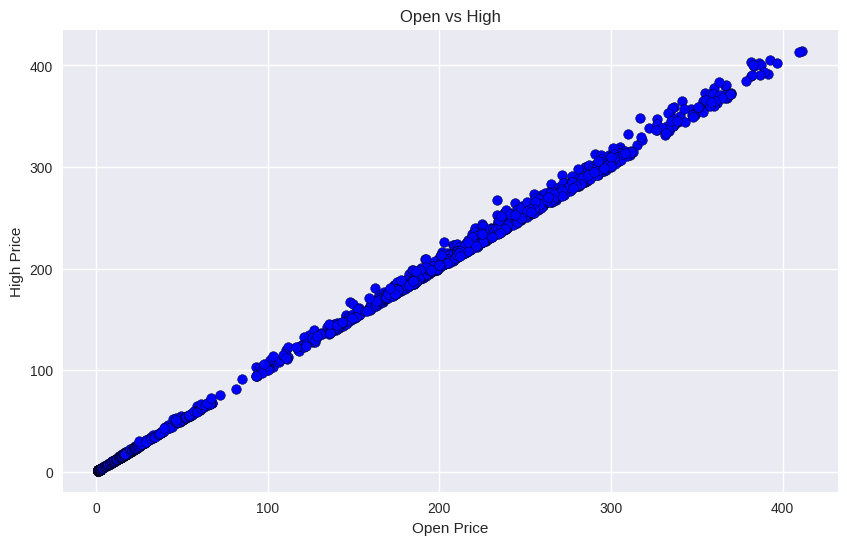

done


In [97]:
plot_open_vs_high(df_tsla)

# 2. Feature Engineering

In [98]:
df_tsla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3.544000e+03
mean,75.461458,77.115431,73.702271,75.445748,75.445748,9.699568e+07
std,102.511170,104.788841,100.035797,102.441247,102.441247,7.867922e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,11.516667,11.859000,11.212500,11.562500,11.562500,4.766288e+07
50%,17.463333,17.688333,17.097334,17.454333,17.454333,8.247975e+07
75%,161.144997,165.218327,157.722497,161.269997,161.269997,1.229246e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


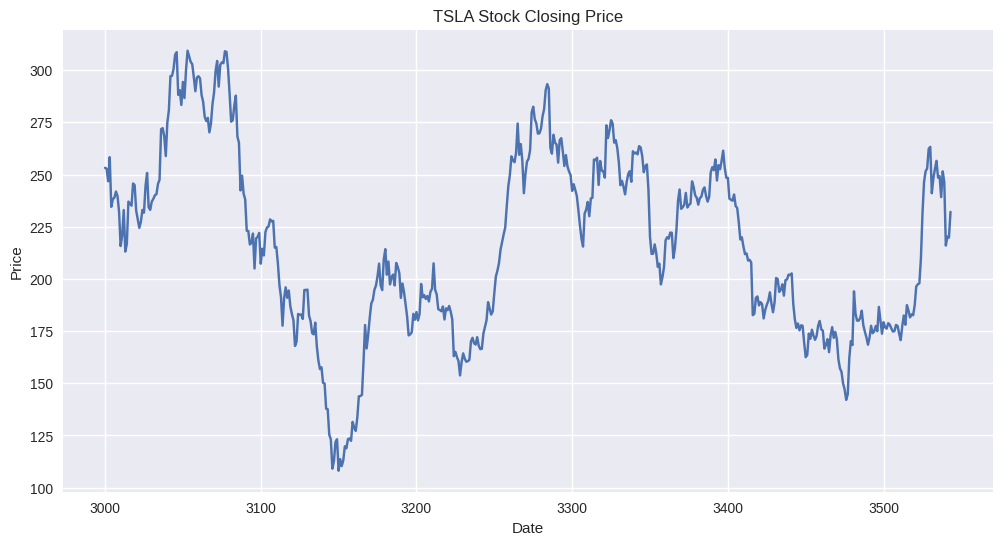

In [99]:
# Plot the closing price
plt.figure(figsize=(12, 6))
# plt.plot(df_tsla.index, gs['Close'])
plt.plot(df_tsla['Close'][3000:])
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## 2.1 Add Extra Features

Text(0.5, 1.0, 'Relative Strength Index (RSI)')

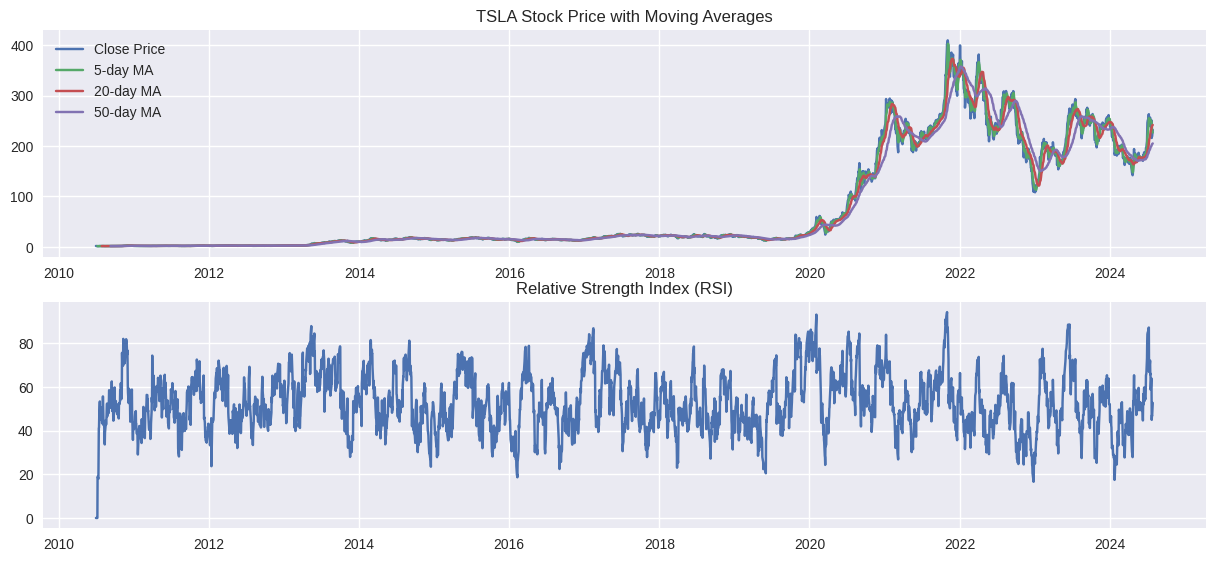

In [100]:
# Assuming 'Date' is your date column. If it's named differently, replace 'Date' with the actual column name
if 'Date' in df_tsla.columns:
    df_tsla.set_index('Date', inplace=True)
    df_tsla.index = pd.to_datetime(df_tsla.index)
else:
    print("No 'Date' column found. Please ensure your DataFrame has a date column.")
    # You might want to add code here to create a date column if it doesn't exist


# 1. Moving Averages
df_tsla['MA5'] = df_tsla['Close'].rolling(window=5).mean()
df_tsla['MA20'] = df_tsla['Close'].rolling(window=20).mean()
df_tsla['MA50'] = df_tsla['Close'].rolling(window=50).mean()

# 2. Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    diff = data.diff()
    up = diff.clip(lower=0)
    down = -1 * diff.clip(upper=0)
    ema_up = up.ewm(com=window - 1, adjust=False).mean()
    ema_down = down.ewm(com=window - 1, adjust=False).mean()
    rs = ema_up / ema_down
    return 100 - (100 / (1 + rs))

df_tsla['RSI'] = compute_rsi(df_tsla['Close'])

# 3. Bollinger Bands
df_tsla['BB_middle'] = df_tsla['Close'].rolling(window=20).mean()
df_tsla['BB_upper'] = df_tsla['BB_middle'] + 2 * df_tsla['Close'].rolling(window=20).std()
df_tsla['BB_lower'] = df_tsla['BB_middle'] - 2 * df_tsla['Close'].rolling(window=20).std()

# 4. Trading Volume Features
df_tsla['Volume_MA5'] = df_tsla['Volume'].rolling(window=5).mean()
df_tsla['Volume_Ratio'] = df_tsla['Volume'] / df_tsla['Volume_MA5']

# 5. Price Momentum
df_tsla['Price_Momentum'] = df_tsla['Close'] - df_tsla['Close'].shift(5)

# 6. Date-based Features
df_tsla['Day_of_Week'] = df_tsla.index.dayofweek
df_tsla['Month'] = df_tsla.index.month
df_tsla['Quarter'] = df_tsla.index.quarter

# Plot some of the engineered features
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df_tsla.index, df_tsla['Close'], label='Close Price')
plt.plot(df_tsla.index, df_tsla['MA5'], label='5-day MA')
plt.plot(df_tsla.index, df_tsla['MA20'], label='20-day MA')
plt.plot(df_tsla.index, df_tsla['MA50'], label='50-day MA')
plt.title('TSLA Stock Price with Moving Averages')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_tsla.index, df_tsla['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI)')

## 2.3 Plot Stock Analysis Charts

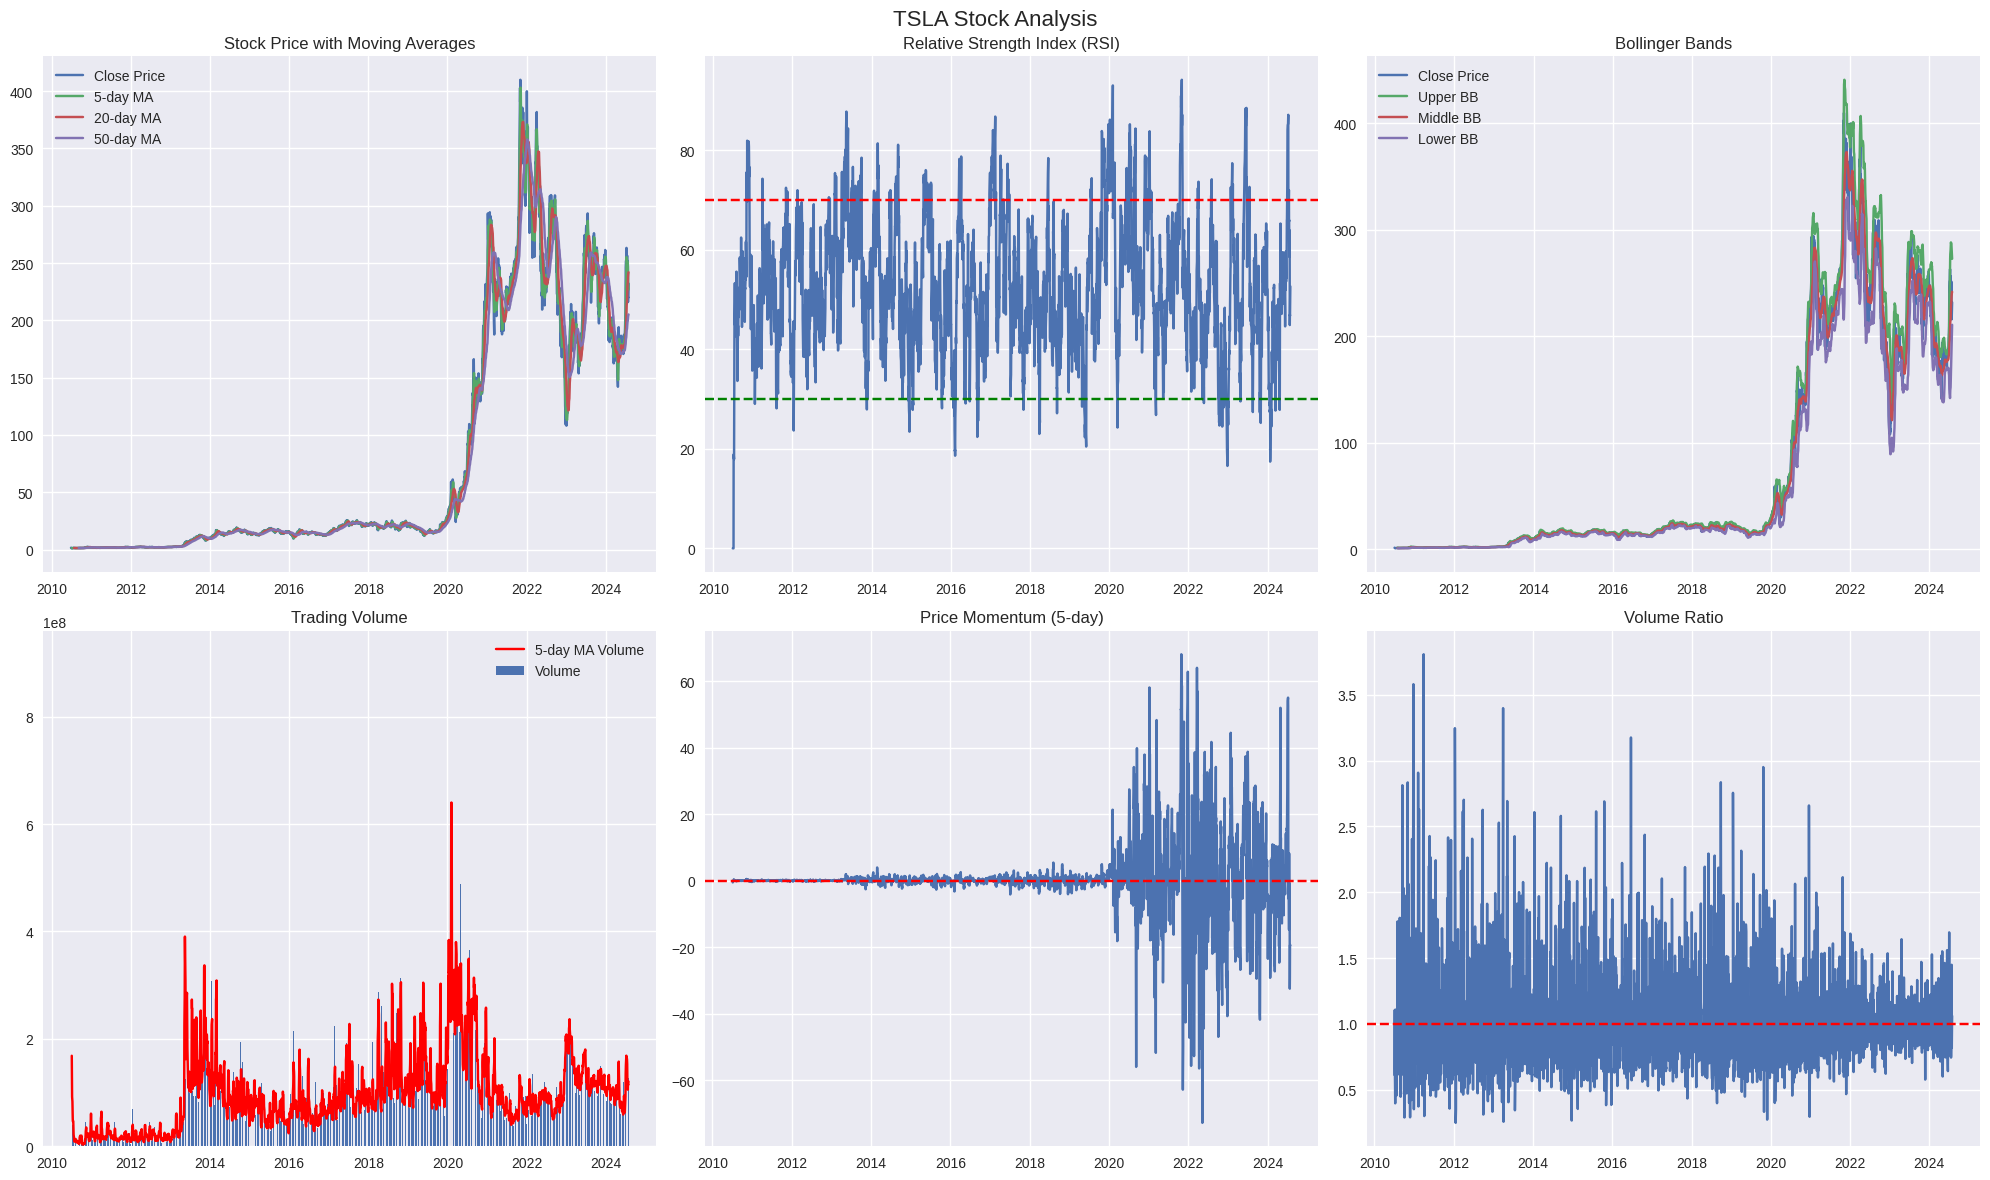

In [101]:
# Create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df_tsla.index, df_tsla['Close'], label='Close Price')
axs[0, 0].plot(df_tsla.index, df_tsla['MA5'], label='5-day MA')
axs[0, 0].plot(df_tsla.index, df_tsla['MA20'], label='20-day MA')
axs[0, 0].plot(df_tsla.index, df_tsla['MA50'], label='50-day MA')
axs[0, 0].set_title('Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df_tsla.index, df_tsla['RSI'], label='RSI')
axs[0, 1].set_title('Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[0, 2].plot(df_tsla.index, df_tsla['Close'], label='Close Price')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_upper'], label='Upper BB')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_middle'], label='Middle BB')
axs[0, 2].plot(df_tsla.index, df_tsla['BB_lower'], label='Lower BB')
axs[0, 2].set_title('Bollinger Bands')
axs[0, 2].legend()

# 4. Volume
axs[1, 0].bar(df_tsla.index, df_tsla['Volume'], label='Volume')
axs[1, 0].plot(df_tsla.index, df_tsla['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 0].set_title('Trading Volume')
axs[1, 0].legend()

# 5. Price Momentum
axs[1, 1].plot(df_tsla.index, df_tsla['Price_Momentum'], label='Price Momentum')
axs[1, 1].set_title('Price Momentum (5-day)')
axs[1, 1].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[1, 2].plot(df_tsla.index, df_tsla['Volume_Ratio'], label='Volume Ratio')
axs[1, 2].set_title('Volume Ratio')
axs[1, 2].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#3. Exploratory Data Analysis

In [102]:
df_tsla.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA5                4
MA20              19
MA50              49
RSI                1
BB_middle         19
BB_upper          19
BB_lower          19
Volume_MA5         4
Volume_Ratio       4
Price_Momentum     5
Day_of_Week        0
Month              0
Quarter            0
dtype: int64

In [103]:
df_tsla.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA5                4
MA20              19
MA50              49
RSI                1
BB_middle         19
BB_upper          19
BB_lower          19
Volume_MA5         4
Volume_Ratio       4
Price_Momentum     5
Day_of_Week        0
Month              0
Quarter            0
dtype: int64

## 3.1 AutoCorrelation and Partial Correlation


>* Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

> * Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### 3.1.1 ACF

Autocorrelation, sometimes known as serial correlation, is the correlation of a time series with a delayed copy of itself as a function of delay. That is, it measures the similarity between observations as a function of the time lag between them. The autocorrelation function can be used basically to detect non-randomness in data and identify cyclical patterns if present.

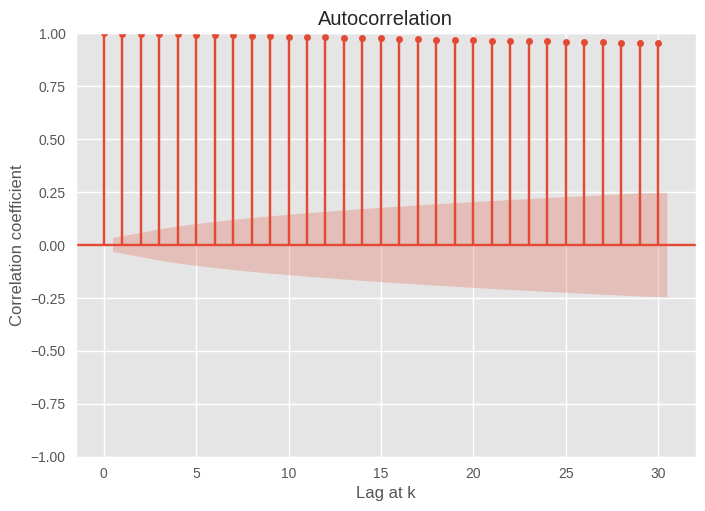

In [104]:
# Assuming df_tsla is your DataFrame and 'Close' is the column with numerical data
numerical_data = df_tsla['Close']

plt.style.use('ggplot')
plot_acf(numerical_data, lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()

### 3.1.2 PACF

The partial autocorrelation function of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

For example, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient α3 of Y_t-3 in the following equation:

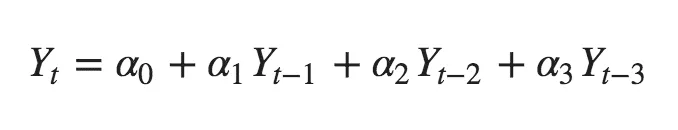

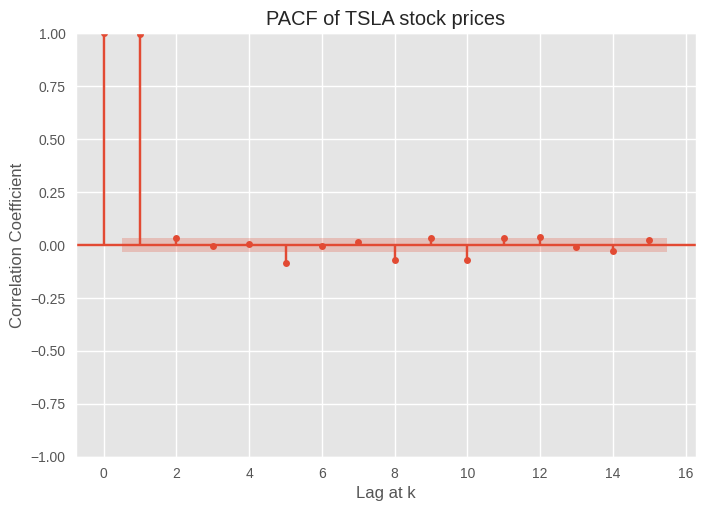

In [105]:
numerical_data = df_tsla['Close']

plt.style.use('ggplot')
plot_pacf(numerical_data, lags=15)
plt.title("PACF of TSLA stock prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()

## 3.2 Stationarity
Most of the time series are non-stationary either it gives an upward or downward trend or seasonal effect. checking the stationarity is the most important thing that we should handle if we want to make a good prediction of such time serie.

#### 3.2.1 Graphical Analysis

**1**- **Lag Plot**:
The stationarity can be checked by looking at Lag plot. A lag plot is used to checks whether the time series data is random or not, and if the data is correlated with themselves. Random data should not have any identifiable patterns, such as linear.

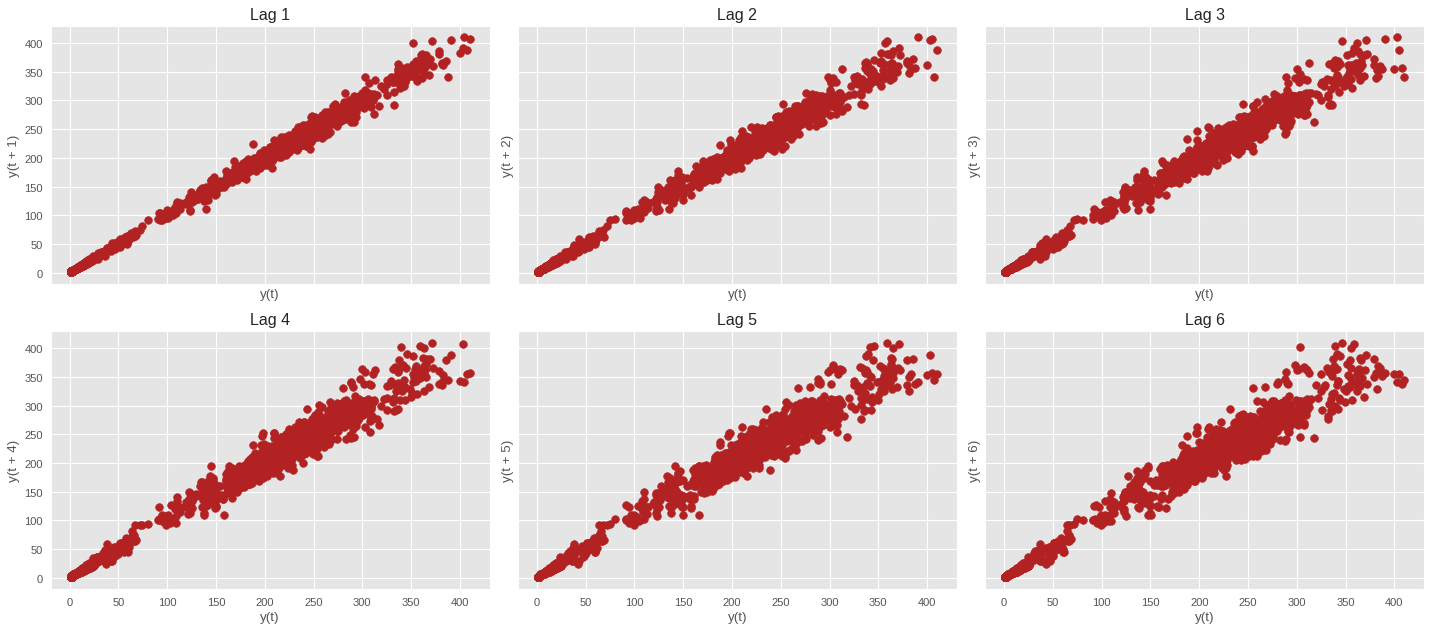

In [106]:
# Assuming df_tsla is your DataFrame and 'Close' is the column with numerical data
numerical_data = df_tsla['Close']

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()[:6]):
    lag_plot(numerical_data, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.tight_layout()
plt.show()

**2**- **Rolling Statistic**:

we can check for stationarity by looking at how rolling average and rolling standard deviation behave in time.

In [107]:
df_tsla.head()

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA50,RSI,BB_middle,BB_upper,BB_lower,Volume_MA5,Volume_Ratio,Price_Momentum,Day_of_Week,Month,Quarter
Date,,,,,,,,,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2,6,2
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3,7,3
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4,7,3
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,1.399867,NaN,NaN,0.0,NaN,NaN,NaN,168536700.0,0.611164,NaN,1,7,3


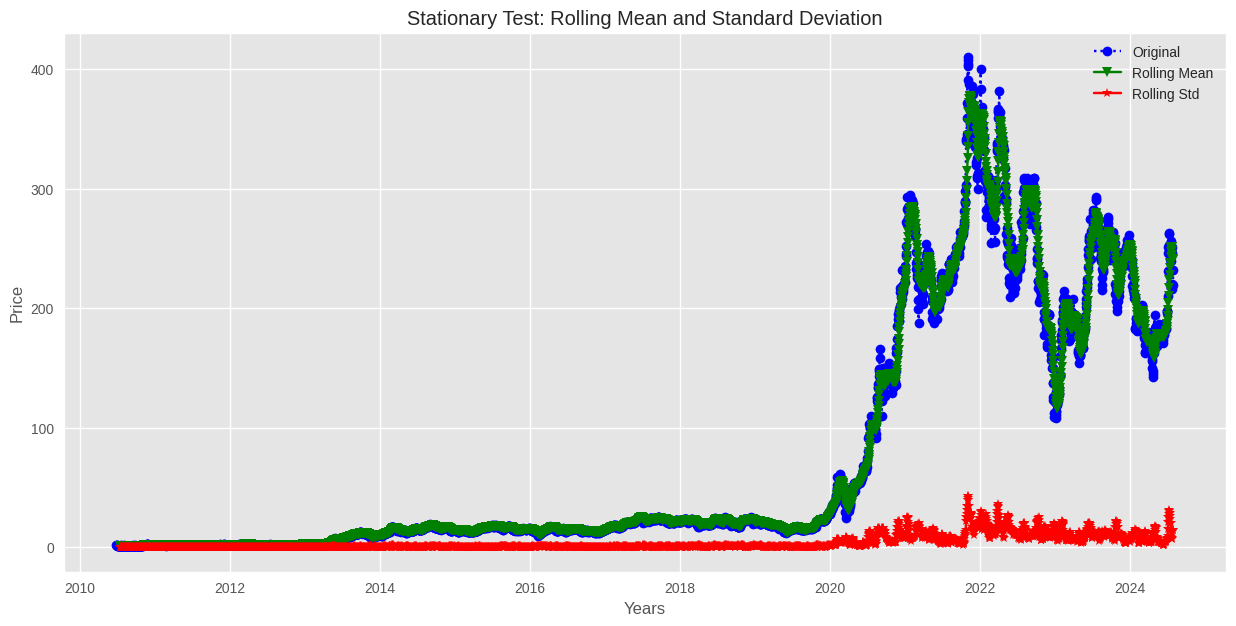

In [108]:
# Ensure 'Close' is numeric
numerical_data = df_tsla['Close']

# Get rolling statistics for window = 12 i.e. yearly statistics
rolling_mean = numerical_data.rolling(window=12).mean()
rolling_std = numerical_data.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stationary Test: Rolling Mean and Standard Deviation')
plt.plot(df_tsla.index, numerical_data, 'b:', marker='o', label='Original')
plt.plot(df_tsla.index, rolling_mean, 'g-', marker='v', label='Rolling Mean')
plt.plot(df_tsla.index, rolling_std, 'r-', marker='*', label='Rolling Std')
plt.legend()
plt.show()

## 3.3 Augmented Dickey Fuller test (ADF Test):
Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.

> * Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
> * Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
> * p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
> * p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

> * Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series.

In [109]:
def stationarity_test(time_series):
    # Ensure input is a Series and has no missing values
    time_series = time_series.dropna()

    df_test = adfuller(time_series)

    print('{:25s} {:.6f}'.format("\033[1m ADF Statistic ", df_test[0]))
    print('{:25s} {:.6f}'.format("\033[1m p-value ", df_test[1]))

    if df_test[0] > df_test[4]["5%"]:
        print("\033[36m\033[1mFailed to Reject Ho - Time Series is Non-Stationary\n")
    else:
        print("\033[36m\033[1mReject Ho - Time Series is Stationary\n")

    a = pd.DataFrame([df_test[4]], index=['Critical Values'])
    return a

In [110]:
# Lets test the stationarity
stationarity_test(df_tsla['Close'])

 ADF Statistic        -1.103908
 p-value              0.713511
Failed to Reject Ho - Time Series is Non-Stationary



,1%,5%,10%
Critical Values,-3.432212,-2.862363,-2.567208


**As** we see the test statistic is way above any critica values and the p-value also way above 0.05. then the time serie has an unit root and is non-stationary.

There is many sort of transformations to make the time series stationary for make it able to be modeled.

### 3.3.1 Differencing:
To transform the series using 'Differencing' we will use the diff() method of pandas.

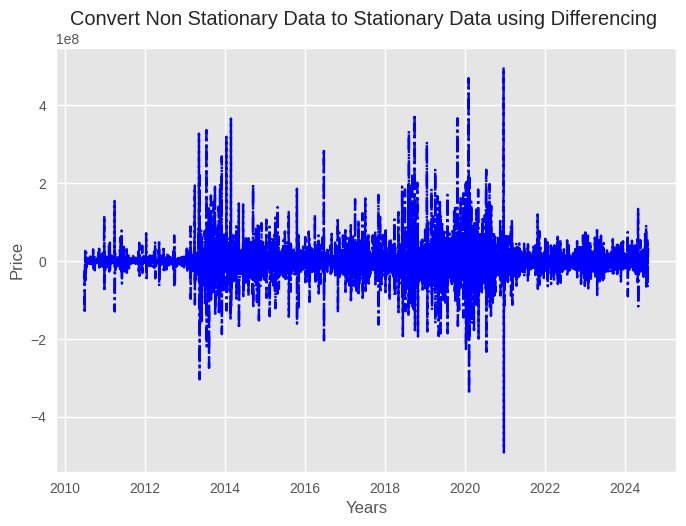

In [111]:
df_tsla_stock = df_tsla.diff(1).bfill() # First order differencing
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_tsla_stock, 'b-.')

In [112]:
def plot_charts(df):

    # Create a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))

    # Plot the distribution of the 'Close' prices
    sns.histplot(df['Close'], bins=50, kde=True, color='royalblue', ax=axs[0, 0])
    axs[0, 0].set_title('Distribution of Close Prices')
    axs[0, 0].set_xlabel('Close Price')
    axs[0, 0].set_ylabel('Frequency')

    # Plot the time series of the 'Close' prices
    df['Close'].plot(ax=axs[0, 1], color='royalblue', legend=True)
    axs[0, 1].set_title('Time Series of Close Prices')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Close Price')
    axs[0, 1].legend(['Close'], loc='upper left')

    # Plot the correlation matrix
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=axs[1, 0])
    axs[1, 0].set_title('Correlation Matrix')

    # Plot the histogram of closing prices with date
    df.reset_index()['Date'].map(lambda x: x.year).hist(bins=50, color='royalblue', edgecolor='black', ax=axs[1, 1])
    axs[1, 1].set_title('Histogram of Closing Prices with Date')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    # Adjust layout
    plt.tight_layout()
    return plt.show()

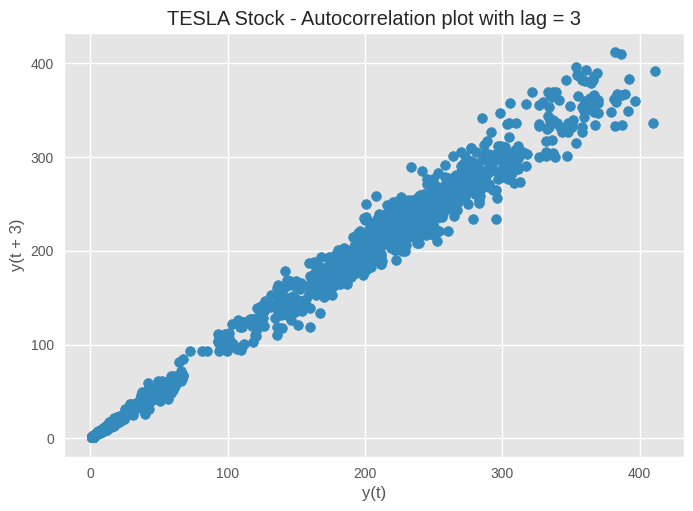

In [113]:
plt.figure()
lag_plot(df_tsla['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

# 4. Autoregressive Integrated Moving Average (ARIMA)


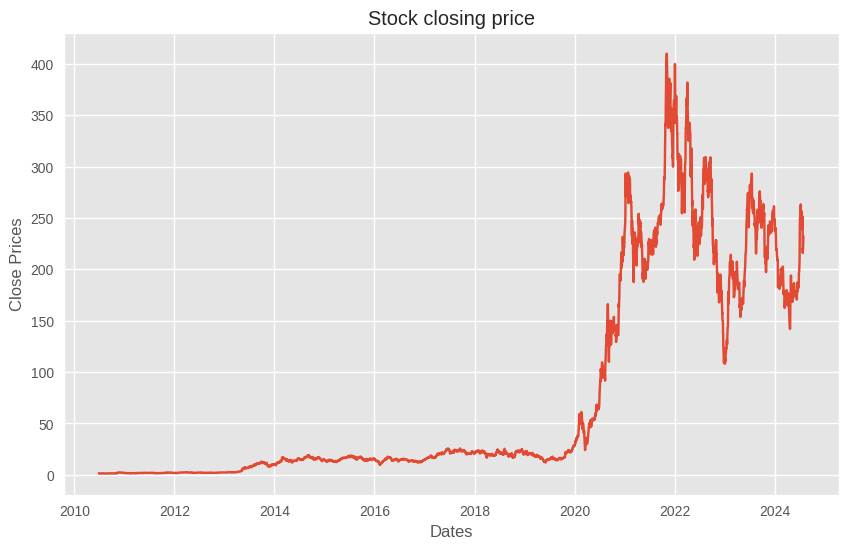

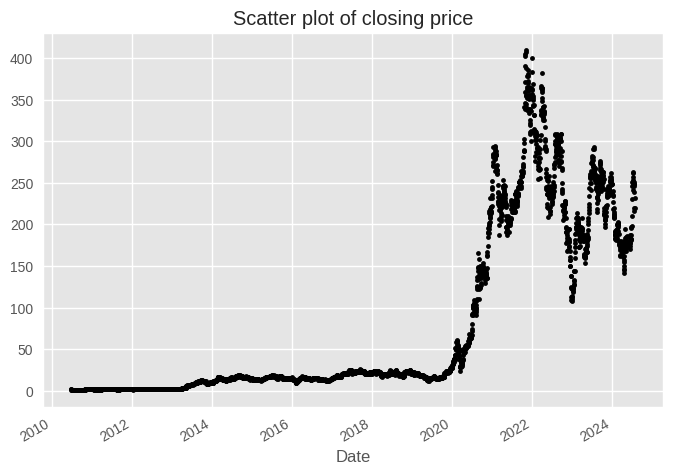

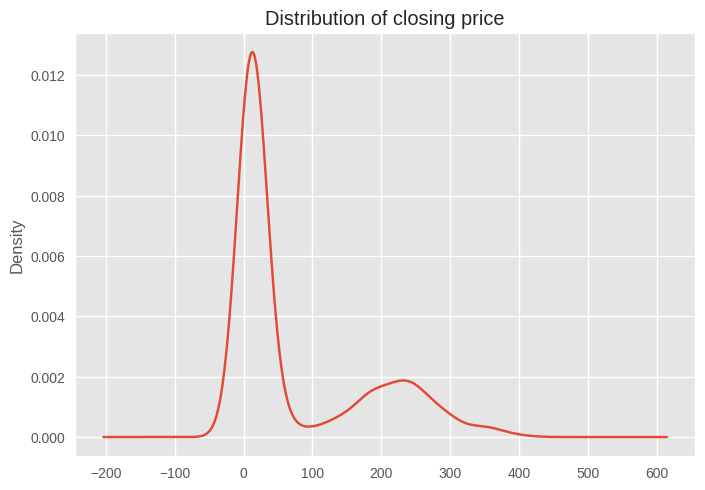

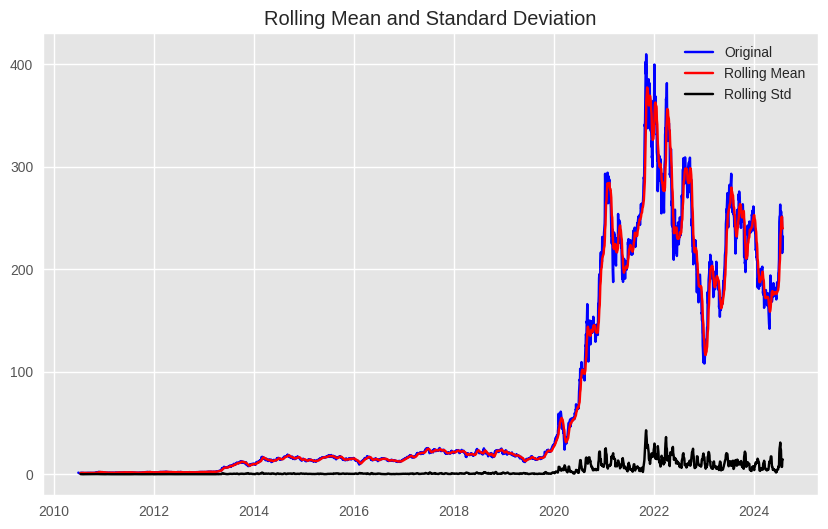

Results of Dickey-Fuller test:
Test Statistics                  -1.103908
p-value                           0.713511
No. of lags used                 29.000000
Number of observations used    3514.000000
Critical Value (1%)              -3.432212
Critical Value (5%)              -2.862363
Critical Value (10%)             -2.567208
dtype: float64


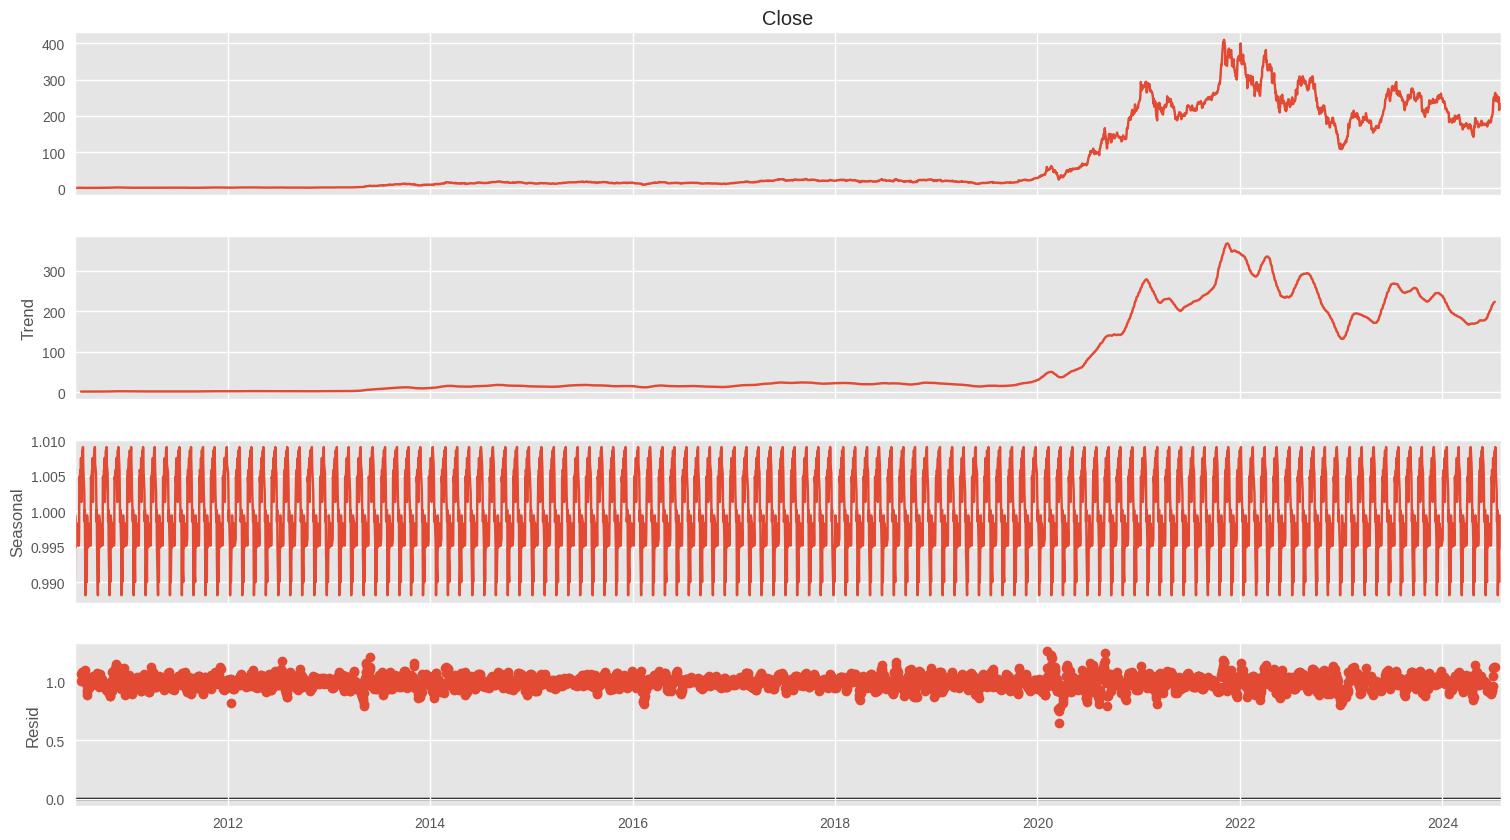

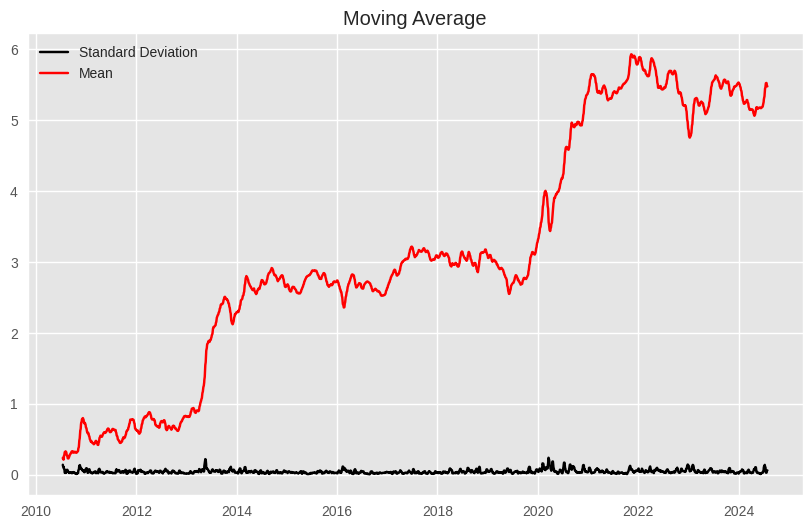

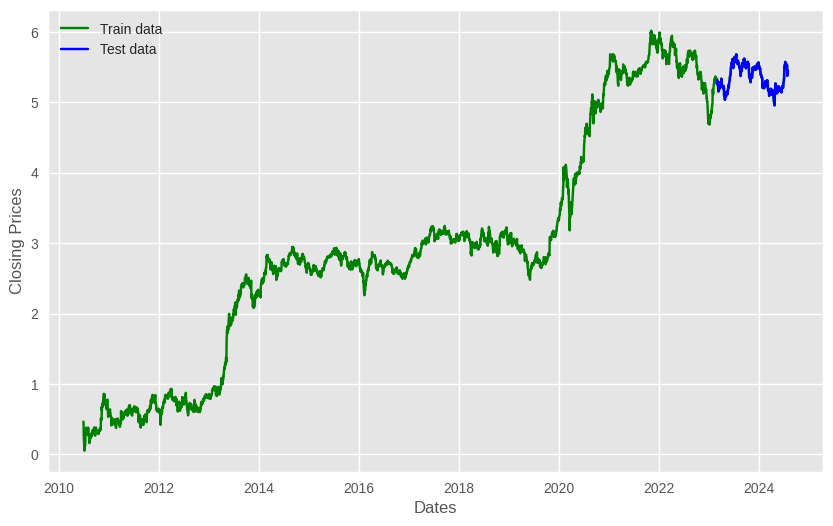

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3186
Model:                 ARIMA(3, 1, 2)   Log Likelihood                6071.000
Date:                Tue, 06 Aug 2024   AIC                         -12130.000
Time:                        17:45:09   BIC                         -12093.603
Sample:                             0   HQIC                        -12116.948
                               - 3186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0052      0.802     -0.007      0.995      -1.577       1.567
ar.L2          0.0018      0.827      0.002      0.998      -1.620       1.624
ar.L3          0.0177      0.016      1.084      0.2

NameError: name 'train_data' is not defined

<Figure size 1000x500 with 0 Axes>

In [160]:
# class StockAnalyzer:
#     def __init__(self, csv_file):
#         self.data = self.load_data(csv_file)
#         self.df_close = self.data['Close']

#     def load_data(self, csv_file):
#         dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
#         return pd.read_csv(csv_file, sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

#     def plot_close_price(self):
#         plt.figure(figsize=(10,6))
#         plt.grid(True)
#         plt.xlabel('Dates')
#         plt.ylabel('Close Prices')
#         plt.plot(self.data['Close'])
#         plt.title('Stock closing price')
#         plt.show()

#     def plot_scatter(self):
#         self.df_close.plot(style='k.')
#         plt.title('Scatter plot of closing price')
#         plt.show()

#     def plot_distribution(self):
#         self.df_close.plot(kind='kde')
#         plt.title('Distribution of closing price')
#         plt.show()

#     def test_stationarity(self):
#         rolmean = self.df_close.rolling(12).mean()
#         rolstd = self.df_close.rolling(12).std()

#         plt.figure(figsize=(10,6))
#         plt.plot(self.df_close, color='blue',label='Original')
#         plt.plot(rolmean, color='red', label='Rolling Mean')
#         plt.plot(rolstd, color='black', label = 'Rolling Std')
#         plt.legend(loc='best')
#         plt.title('Rolling Mean and Standard Deviation')
#         plt.show()

#         print("Results of Dickey-Fuller test:")
#         adft = adfuller(self.df_close, autolag='AIC')
#         output = pd.Series(adft[0:4], index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
#         for key, value in adft[4].items():
#             output[f'Critical Value ({key})'] = value
#         print(output)

#     def decompose_series(self):
#         result = seasonal_decompose(self.df_close, model='multiplicative', period=30)
#         fig = result.plot()
#         fig.set_size_inches(16, 9)
#         plt.show()

#     def plot_moving_average(self):
#         df_log = np.log(self.df_close)
#         moving_avg = df_log.rolling(12).mean()
#         std_dev = df_log.rolling(12).std()

#         plt.figure(figsize=(10,6))
#         plt.plot(std_dev, color="black", label="Standard Deviation")
#         plt.plot(moving_avg, color="red", label="Mean")
#         plt.legend(loc='best')
#         plt.title('Moving Average')
#         plt.show()

#     def split_data(self):
#         df_log = np.log(self.df_close)
#         train_data = df_log[3:int(len(df_log)*0.9)]
#         test_data = df_log[int(len(df_log)*0.9):]

#         plt.figure(figsize=(10,6))
#         plt.grid(True)
#         plt.xlabel('Dates')
#         plt.ylabel('Closing Prices')
#         plt.plot(df_log, 'green', label='Train data')
#         plt.plot(test_data, 'blue', label='Test data')
#         plt.legend()
#         plt.show()

#         return train_data, test_data

#     def build_arima_model(self, train_data):
#         model = ARIMA(train_data, order=(3, 1, 2))
#         fitted = model.fit()
#         print(fitted.summary())
#         return fitted

#     def forecast(self, fitted, test_data):
#         forecast_results = fitted.get_forecast(steps=len(test_data))
#         fc = forecast_results.predicted_mean
#         se = forecast_results.se_mean
#         conf = forecast_results.conf_int(alpha=0.05)

#         fc_series = pd.Series(fc, index=test_data.index)
#         lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
#         upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

#         plt.figure(figsize=(10,5), dpi=100)
#         plt.plot(train_data, label='training')
#         plt.plot(test_data, color='blue', label='Actual Stock Price')
#         plt.plot(fc_series, color='orange', label='Predicted Stock Price')
#         plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
#         plt.title('Stock Price Prediction')
#         plt.xlabel('Time')
#         plt.ylabel('Stock Price')
#         plt.legend(loc='upper left', fontsize=8)
#         plt.show()

#         return fc

#     def evaluate_model(self, test_data, fc):
#         mse = mean_squared_error(test_data, fc)
#         mae = mean_absolute_error(test_data, fc)
#         rmse = math.sqrt(mse)
#         mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))

#         print(f'MSE: {mse}')
#         print(f'MAE: {mae}')
#         print(f'RMSE: {rmse}')
#         print(f'MAPE: {mape}')

# def main():
#     analyzer = StockAnalyzer('./TSLA.csv')
#     analyzer.plot_close_price()
#     analyzer.plot_scatter()
#     analyzer.plot_distribution()
#     analyzer.test_stationarity()
#     analyzer.decompose_series()
#     analyzer.plot_moving_average()
#     train_data, test_data = analyzer.split_data()
#     fitted_model = analyzer.build_arima_model(train_data)
#     fc = analyzer.forecast(fitted_model, test_data)
#     analyzer.evaluate_model(test_data, fc)

# if __name__ == "__main__":
#     main()

In [115]:
class ARIMAStockForecast:
    def __init__(self, df, column='Close', test_size=0.2):
        self.df = df
        self.column = column
        self.test_size = test_size
        self.train = None
        self.valid = None
        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None

    def prepare_data(self):
        close_prices = self.df[self.column]
        self.train, self.valid = train_test_split(close_prices, test_size=self.test_size, shuffle=False)

    def grid_search(self):
        p = d = q = range(0, 6)
        pdq = list(itertools.product(p, d, q))

        for param in pdq:
            try:
                model = ARIMA(self.train, order=param)
                results = model.fit()
                forecast = results.forecast(steps=len(self.valid))
                rmse = np.sqrt(mean_squared_error(self.valid, forecast))
                if rmse < self.best_rmse:
                    self.best_rmse = rmse
                    self.best_order = param
            except:
                continue

        print(f"Best ARIMA order: {self.best_order}")
        print(f"Best RMSE: {self.best_rmse}")

    def fit_best_model(self):
        self.best_model = ARIMA(self.train, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        self.forecast = self.best_model.forecast(steps=len(self.valid))

    def plot_results(self):
        plt.figure(figsize=(12,6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.valid.index, self.valid, label='Validation Data')
        plt.plot(self.valid.index, self.forecast, label='Forecast')
        plt.legend()
        plt.title('Stock Price Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()

    def print_evaluation_metrics(self):
        mse = mean_squared_error(self.valid, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def run_forecast(self):
        self.prepare_data()
        self.grid_search()
        self.fit_best_model()
        self.make_forecast()
        self.plot_results()
        self.print_evaluation_metrics()

In [116]:
# Assuming you have a DataFrame 'df' with your stock data
model = ARIMAStockForecast(df)

Best ARIMA order: (2, 0, 1)
Best RMSE: 13.184721974174371


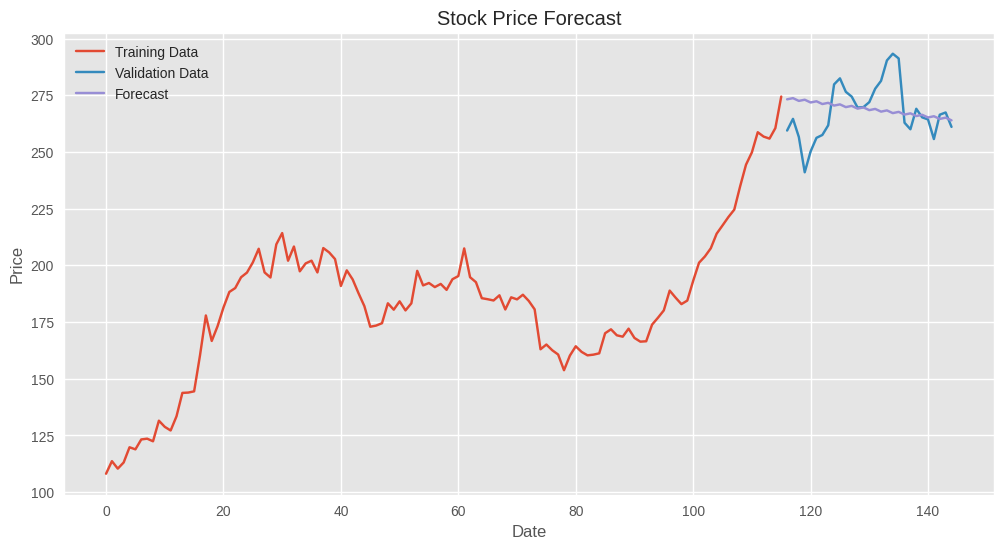

Final Mean Squared Error: 173.8368935362765
Final Root Mean Squared Error: 13.184721974174371


In [117]:
model.run_forecast()

In [118]:
train_set = model.train
valid_set = model.valid

In [119]:
best_order = model.best_order
best_rmse = model.best_rmse
forecast = model.forecast

Best ARIMA order: (2, 0, 1)
Best RMSE: 13.184721974174371


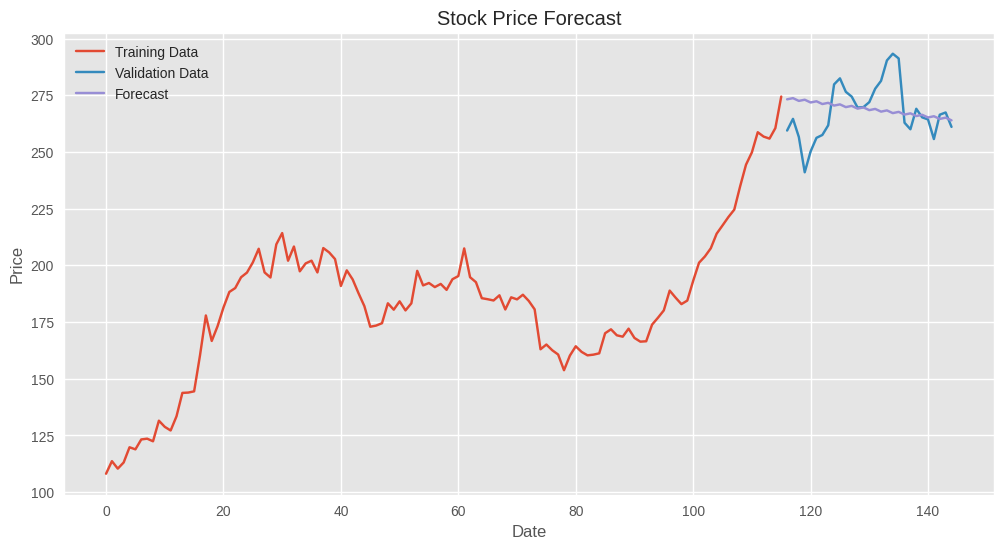

Final Mean Squared Error: 173.8368935362765
Final Root Mean Squared Error: 13.184721974174371


In [120]:
model.prepare_data()
model.grid_search()
model.fit_best_model()
model.make_forecast()
model.plot_results()
model.print_evaluation_metrics()

## 4.1 Simple ARIMA

In [121]:
class ArimaModel:
    def __init__(self, df):
        self.close_prices = df['Close']
        self.train = None
        self.valid = None
        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None

    def split_data(self, test_size=0.2):
        self.train, self.valid = train_test_split(self.close_prices, test_size=test_size, shuffle=False)

    def grid_search(self, max_order=6):
        p = d = q = range(0, max_order + 1)
        pdq = list(itertools.product(p, d, q))

        for param in pdq:
            try:
                model = ARIMA(self.train, order=param)
                results = model.fit()
                forecast = results.forecast(steps=len(self.valid))
                rmse = np.sqrt(mean_squared_error(self.valid, forecast))
                if rmse < self.best_rmse:
                    self.best_rmse = rmse
                    self.best_order = param
            except:
                continue

        print(f"Best ARIMA order: {self.best_order}")
        print(f"Best RMSE: {self.best_rmse}")

    def fit_best_model(self):
        self.best_model = ARIMA(self.train, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        self.forecast = self.best_model.forecast(steps=len(self.valid))

    def plot_results(self):
        plt.figure(figsize=(12,6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.valid.index, self.valid, label='Validation Data')
        plt.plot(self.valid.index, self.forecast, label='Forecast')
        plt.legend()
        plt.title('Stock Price Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()

    def print_evaluation_metrics(self):
        mse = mean_squared_error(self.valid, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def run_forecast(self):
        self.split_data()
        self.grid_search()
        self.fit_best_model()
        self.make_forecast()
        self.plot_results()
        self.print_evaluation_metrics()

In [122]:
arima_model = ArimaModel(df)

Best ARIMA order: (2, 0, 1)
Best RMSE: 13.184721974174371


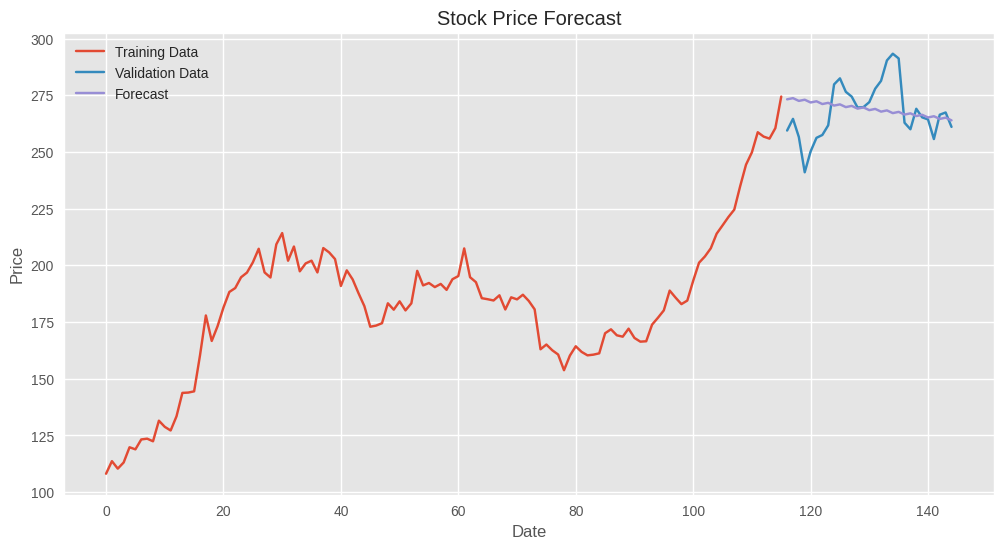

Final Mean Squared Error: 173.8368935362765
Final Root Mean Squared Error: 13.184721974174371


In [123]:
arima_model.run_forecast()

In [124]:
class ARIMAModel:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.model_order = (0, 1, 0)
        self.train = None
        self.test = None
        self.dataset_ex_df = None
        self.history = None
        self.predictions = []

    def download_data(self):
        # Download data from Yahoo Finance
        gs = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        self.dataset_ex_df = gs[['Close']].copy()
        self.dataset_ex_df.reset_index(inplace=True)
        self.dataset_ex_df['Date'] = pd.to_datetime(self.dataset_ex_df['Date'])
        self.dataset_ex_df.set_index('Date', inplace=True)

    def determine_arima_order(self):
        # Auto ARIMA to determine the best order
        model = auto_arima(self.dataset_ex_df['Close'], seasonal=False, trace=True,
                          error_action='ignore', suppress_warnings=True,
                          stepwise=True)
        self.model_order = model.order
        print(f"Best ARIMA order: {self.model_order}")
        # print(model.summary())

    def split_data(self, train_ratio=0.8):
        # Split data into training and testing sets
        X = self.dataset_ex_df['Close'].values
        size = int(len(X) * train_ratio)
        self.train, self.test = X[:size], X[size:]
        self.history = [x for x in self.train]

    def arima_forecast(self):
        # Fit ARIMA model and make a forecast
        model = ARIMA(self.history, order=self.model_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        return output[0]

    def walk_forward_validation(self):
        # Perform walk-forward validation and store predictions
        self.predictions = []
        for t in range(len(self.test)):
            yhat = self.arima_forecast()
            self.predictions.append(yhat)
            obs = self.test[t]
            self.history.append(obs)

        # Calculate and print evaluation metrics
        self.calculate_metrics()

    def calculate_metrics(self):
        # Calculate and print evaluation metrics
        mse = mean_squared_error(self.test, self.predictions)
        mae = mean_absolute_error(self.test, self.predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((self.test - self.predictions) / self.test)) * 100

        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')
        print(f'RMSE: {rmse:.4f}')
        print(f'MAPE: {mape:.2f}%')

    def print_model_summary(self):
        """
            the ARIMA class in statsmodels is essentially a simplified version of the SARIMAX model that excludes the seasonal components.
            The SARIMAX class is a more general framework that can handle both seasonal and non-seasonal components,
            but ARIMA is essentially a special case of SARIMAX with no seasonal components.
        """
        # Fit the ARIMA model
        model = ARIMA(self.history, order=self.model_order)
        model_fit = model.fit()

        # Get the original summary
        original_summary = model_fit.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")

        # Print summary of the model
        print(modified_summary)

        # Extract and print coefficients
        # For ARIMA(0, 1, 0), there's only the sigma2 parameter
        params = model_fit.params
        print("Model Coefficients:")
        if len(params) == 1:
            # Only sigma2 is available
            print(f"sigma2: {params[0]:.4f}")
        else:
            for param_name, value in zip(model_fit.param_names, params):
                print(f"{param_name}: {value:.4f}")

    def plot_results(self):
        # Plot the results of the predictions
        size = len(self.train)
        plt.figure(figsize=(12, 6), dpi=100)
        plt.plot(self.dataset_ex_df.index[:size], self.train, color='blue', label='Training Data')
        plt.plot(self.dataset_ex_df.index[size:], self.test, color='green', label='Actual Data')
        plt.plot(self.dataset_ex_df.index[size:], self.predictions, color='red', linestyle='dashed', label='Forecasted Data')
        plt.title('ARIMA Predictions vs Actual Values')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


In [125]:
arima_model = ARIMAModel(ticker=TICKER, start_date="2020-01-01", end_date="2024-01-01")

In [126]:
arima_model.download_data()

[*********************100%%**********************]  1 of 1 completed


In [127]:
arima_model.determine_arima_order()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7175.036, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7168.729, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7169.771, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7169.796, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7167.387, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7171.049, Time=0.58 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.813 seconds
Best ARIMA order: (0, 1, 0)


In [128]:
arima_model.split_data()

In [129]:
arima_model.walk_forward_validation()

MSE: 49.3248
MAE: 5.2480
RMSE: 7.0232
MAPE: 2.30%


In [130]:
arima_model.calculate_metrics()

MSE: 49.3248
MAE: 5.2480
RMSE: 7.0232
MAPE: 2.30%


In [131]:
arima_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3582.694
Date:                Tue, 06 Aug 2024   AIC                           7167.387
Time:                        17:34:41   BIC                           7172.300
Sample:                             0   HQIC                          7169.254
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        73.1040      1.938     37.719      0.000      69.305      76.903
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):               571.63
Prob(Q):                              0.33   Prob

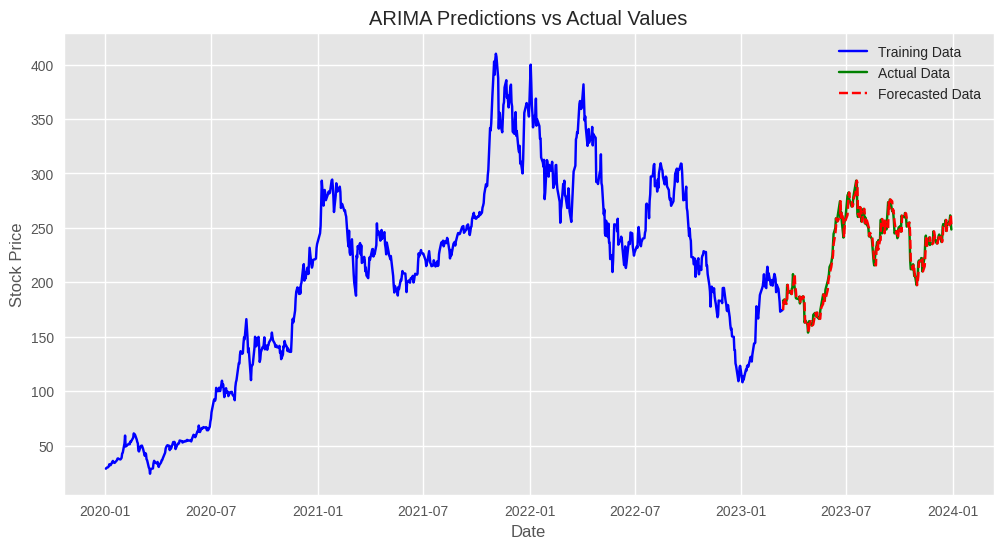

In [132]:
arima_model.plot_results()

## 4.2 ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables)


Explanation of exog_tickers
The exog_tickers parameter is a list of ticker symbols for exogenous variables. These are additional time series that are used as external regressors in the ARIMAX model. In the provided example, exog_tickers includes ['MSFT', 'GOOGL'], which means the closing prices of Microsoft (MSFT) and Google (GOOGL) stocks are used as exogenous variables to help predict the closing price of Apple (AAPL).

Plan for ARIMAX Model Analysis
To efficiently run the ARIMAX model analysis, we will break down the process into different cells. This will help avoid repeating prior steps and make the code more modular and easier to debug.

Import Libraries and Define the ARIMAXModel Class: This cell will include all necessary imports and the definition of the ARIMAXModel class.
Download Data: This cell will create an instance of the ARIMAXModel class and download the data.
Determine ARIMAX Order: This cell will determine the best ARIMAX model order using the auto_arima function.
Walk-Forward Validation: This cell will perform walk-forward validation, make predictions, and plot the results.

In [133]:
class ARIMAXModel:
    def __init__(self, ticker, start_date, end_date, exog_vars):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.exog_vars = exog_vars
        self.model_order = (0, 1, 0)
        self.train = None
        self.test = None
        self.train_exog = None
        self.test_exog = None
        self.dataset_ex_df = None
        self.history = None
        self.history_exog = None
        self.predictions = []
        self.best_orders = []

    def download_data(self):
        ticker = yf.Ticker(self.ticker)
        self.dataset_ex_df = ticker.history(start=self.start_date, end=self.end_date)
        self.dataset_ex_df.reset_index(inplace=True)
        self.dataset_ex_df['Date'] = pd.to_datetime(self.dataset_ex_df['Date'])
        self.dataset_ex_df.set_index('Date', inplace=True)

        # Drop any rows with missing values
        self.dataset_ex_df.dropna(inplace=True)

        print("Data downloaded and processed. Shape of the dataset:")
        print(self.dataset_ex_df.shape)
        print("\nFirst few rows of the dataset:")
        print(self.dataset_ex_df.head())

    def determine_arimax_order(self):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        model = auto_arima(endog, exogenous=exog, seasonal=False, trace=True, suppress_warnings=True)
        self.model_order = model.order
        print("Best ARIMAX model order:", self.model_order)
        print("Model summary:")
        print(model.summary())

    def grid_search_arimax_order(self):
        p_values = range(0, 6)
        d_values = range(0, 6)
        q_values = range(0, 6)
        results = []

        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = ARIMA(endog, exog=exog, order=(p, d, q))
                        model_fit = model.fit()
                        mse = mean_squared_error(endog, model_fit.fittedvalues)
                        results.append(((p, d, q), mse, model_fit))
                        print(f'ARIMAX order {(p, d, q)} MSE={mse}')
                    except Exception as e:
                        continue

        results.sort(key=lambda x: x[1])
        self.best_orders = results[:5]
        self.model_order = self.best_orders[0][0]

        metrics = ['Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC']
        metrics_data = []

        for order, mse, model_fit in self.best_orders:
            y_true = endog
            y_pred = model_fit.fittedvalues
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
            mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive forecast method
            r_squared = r2_score(y_true, y_pred)
            adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(model_fit.params) - 1)
            aic = model_fit.aic
            bic = model_fit.bic

            metrics_data.append([order, mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic])

        best_orders_df = pd.DataFrame(metrics_data, columns=metrics)
        print("Top 5 ARIMAX model orders with evaluation metrics:")
        print(best_orders_df)

        return best_orders_df

    def arima_forecast(self, history, history_exog, exog):
        model = ARIMA(history, exog=np.array(history_exog), order=self.model_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1, exog=exog)
        return forecast[0]

    def walk_forward_validation(self, test_size=0.2):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        self.train, self.test, self.train_exog, self.test_exog = train_test_split(
            endog, exog, test_size=test_size, shuffle=False
        )

        self.history = [x for x in self.train]
        self.history_exog = self.train_exog.values.tolist()

        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1].values
            yhat = self.arima_forecast(self.history, self.history_exog, exog)
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog[0])
            print('Predicted: ' + str(yhat) + ', Expected: ' + str(obs))

        mse = np.mean((self.test - self.predictions) ** 2)
        rmse = np.sqrt(mse)
        print('Test RMSE: ' + str(rmse))

        # Plotting the results
        plt.figure(figsize=(14, 7))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label=f'Forecast (Order: {self.model_order})', color='green')
        plt.title(f'ARIMAX Forecast for {self.ticker} (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


In [134]:
arimax_model = ARIMAXModel(ticker='TSLA', start_date='2023-01-01', end_date='2023-08-02', exog_vars=['Open', 'High', 'Low', 'Volume'])

In [135]:
arimax_model.download_data()

Data downloaded and processed. Shape of the dataset:
(145, 7)

First few rows of the dataset:
                                 Open        High         Low       Close  \
Date                                                                        
2023-01-03 00:00:00-05:00  118.470001  118.800003  104.639999  108.099998   
2023-01-04 00:00:00-05:00  109.110001  114.589996  107.519997  113.639999   
2023-01-05 00:00:00-05:00  110.510002  111.750000  107.160004  110.339996   
2023-01-06 00:00:00-05:00  103.000000  114.389999  101.809998  113.059998   
2023-01-09 00:00:00-05:00  118.959999  123.519997  117.110001  119.769997   

                              Volume  Dividends  Stock Splits  
Date                                                           
2023-01-03 00:00:00-05:00  231402800        0.0           0.0  
2023-01-04 00:00:00-05:00  180389000        0.0           0.0  
2023-01-05 00:00:00-05:00  157986300        0.0           0.0  
2023-01-06 00:00:00-05:00  220911100        0.

In [136]:
best_orders_df = arimax_model.grid_search_arimax_order()  # Grid search for the best order

ARIMAX order (0, 0, 0) MSE=5.30667269331606
ARIMAX order (0, 0, 1) MSE=5.192683587036004
ARIMAX order (0, 0, 2) MSE=4.963633966507215
ARIMAX order (0, 0, 3) MSE=4.961290771299982
ARIMAX order (0, 0, 4) MSE=4.918142013717019
ARIMAX order (0, 0, 5) MSE=4.827592520358904
ARIMAX order (0, 1, 0) MSE=14.673798201620434
ARIMAX order (0, 1, 1) MSE=12.082263168850979
ARIMAX order (0, 1, 2) MSE=12.11932213795025
ARIMAX order (0, 1, 3) MSE=11.920346758108314
ARIMAX order (0, 1, 4) MSE=11.804272626993798
ARIMAX order (0, 1, 5) MSE=11.79774349241097
ARIMAX order (0, 2, 0) MSE=40.894509803101364
ARIMAX order (0, 2, 1) MSE=40.883521736875906
ARIMAX order (0, 2, 2) MSE=40.88351778249797
ARIMAX order (0, 2, 3) MSE=22.101292397383638
ARIMAX order (0, 2, 4) MSE=40.883513205093635
ARIMAX order (0, 2, 5) MSE=22.08406146972041
ARIMAX order (0, 3, 0) MSE=117.08979890987007
ARIMAX order (0, 3, 1) MSE=116.95401597756239
ARIMAX order (0, 3, 2) MSE=42.65028123993527
ARIMAX order (0, 3, 3) MSE=116.95387440579148


Predicted: 261.99089703142704, Expected: 259.4599914550781
Predicted: 260.2398175435652, Expected: 264.6099853515625
Predicted: 256.1462771541446, Expected: 256.6000061035156
Predicted: 248.58450975453263, Expected: 241.0500030517578
Predicted: 247.76658556309718, Expected: 250.2100067138672
Predicted: 257.80885136648004, Expected: 256.239990234375
Predicted: 263.6314813864833, Expected: 257.5
Predicted: 264.1821874890072, Expected: 261.7699890136719
Predicted: 281.9898041356253, Expected: 279.82000732421875
Predicted: 282.37313611648733, Expected: 282.4800109863281
Predicted: 275.4100878024231, Expected: 276.5400085449219
Predicted: 276.6926745271255, Expected: 274.42999267578125
Predicted: 265.160276608178, Expected: 269.6099853515625
Predicted: 269.175560072921, Expected: 269.7900085449219
Predicted: 272.34333003956834, Expected: 271.989990234375
Predicted: 276.6522176908819, Expected: 277.8999938964844
Predicted: 282.92162694061625, Expected: 281.3800048828125
Predicted: 289.090615

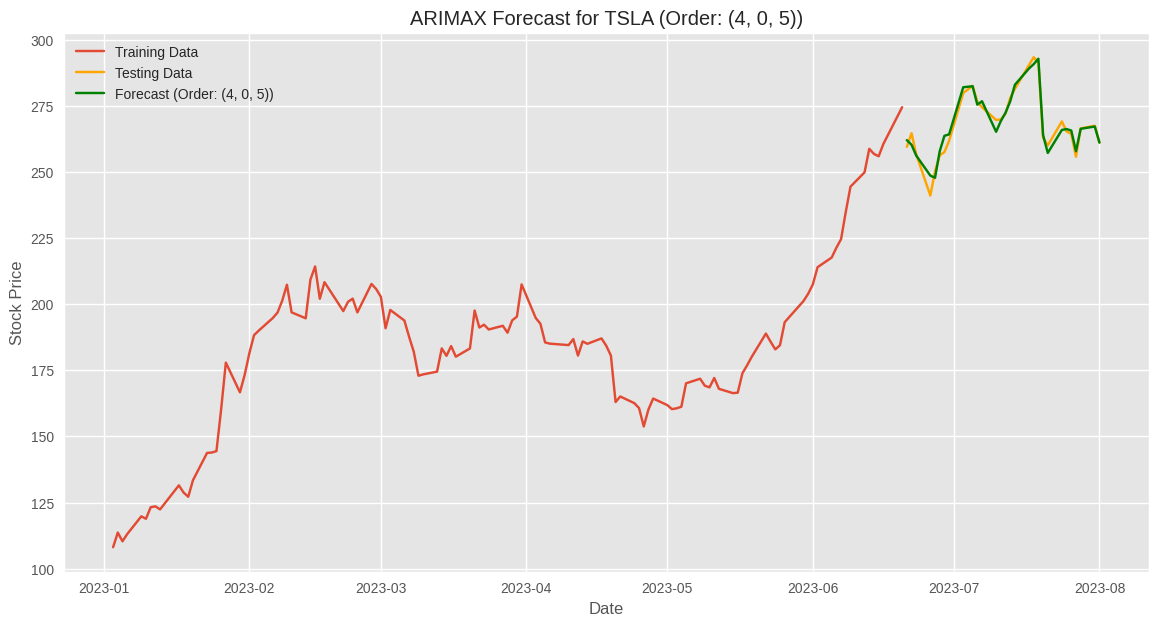

In [137]:
# arimax_model.determine_arimax_order()  # Optionally, use auto_arima for optimal searching
arimax_model.walk_forward_validation()

In [138]:
print("Top 5 ARIMAX model orders with their evaluation metrics:")
best_orders_df

Top 5 ARIMAX model orders with their evaluation metrics:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
0,"(4, 0, 5)",4.704240,1.678795,2.168926,0.866154,0.865537,inf,0.997696,0.997428,666.627884,711.278890
1,"(5, 0, 3)",4.706001,1.681928,2.169332,0.868483,0.867868,inf,0.997695,0.997447,664.490934,706.165206
2,"(5, 0, 4)",4.706626,1.681482,2.169476,0.868252,0.867624,inf,0.997695,0.997427,666.714425,711.365431
3,"(4, 0, 4)",4.710502,1.683103,2.170369,0.868606,0.867980,inf,0.997693,0.997444,664.823528,706.497800
4,"(5, 0, 0)",4.712198,1.695720,2.170760,0.874477,0.873834,inf,0.997692,0.997501,658.563326,691.307397


## 4.3 Autoregressive fractionally integrated moving average (AFRIMA)

In [139]:
class AFRIMAModel:
    def __init__(self, ticker, start_date, end_date, exog_vars):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.exog_vars = exog_vars
        self.model_order = (0, 1, 0)
        self.train = None
        self.test = None
        self.train_exog = None
        self.test_exog = None
        self.dataset_ex_df = None
        self.history = None
        self.history_exog = None
        self.predictions = []
        self.best_orders = []

    def download_data(self):
        ticker = yf.Ticker(self.ticker)
        self.dataset_ex_df = ticker.history(start=self.start_date, end=self.end_date)
        self.dataset_ex_df.reset_index(inplace=True)
        self.dataset_ex_df['Date'] = pd.to_datetime(self.dataset_ex_df['Date'])
        self.dataset_ex_df.set_index('Date', inplace=True)

        # Drop any rows with missing values
        self.dataset_ex_df.dropna(inplace=True)

        print("Data downloaded and processed. Shape of the dataset:")
        print(self.dataset_ex_df.shape)
        print("\nFirst few rows of the dataset:")
        print(self.dataset_ex_df.head())

    def determine_afrima_order(self):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        model = auto_arima(endog, exogenous=exog, seasonal=False, trace=True, suppress_warnings=True, with_intercept=False)
        self.model_order = model.order
        print("Best AFRIMA model order:", self.model_order)
        print("Model summary:")
        print(model.summary())

    def grid_search_afrima_order(self):
        p_values = range(0, 6)
        d_values = [0.5]  # Fractionally integrated
        q_values = range(0, 6)
        results = []

        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = auto_arima(endog, exogenous=exog, order=(p, d, q), seasonal=False, suppress_warnings=True, with_intercept=False)
                        model_fit = model.fit(endog, exogenous=exog)
                        mse = mean_squared_error(endog, model_fit.predict_in_sample())
                        results.append(((p, d, q), mse, model_fit))
                        print(f'AFRIMA order {(p, d, q)} MSE={mse}')
                    except Exception as e:
                        continue

        results.sort(key=lambda x: x[1])
        self.best_orders = results[:5]
        self.model_order = self.best_orders[0][0]

        metrics = ['Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC']
        metrics_data = []

        for order, mse, model_fit in self.best_orders:
            y_true = endog
            y_pred = model_fit.predict_in_sample()
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
            mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive forecast method
            r_squared = r2_score(y_true, y_pred)
            adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(model_fit.params()) - 1)
            aic = model_fit.aic()
            bic = model_fit.bic()

            metrics_data.append([order, mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic])

        best_orders_df = pd.DataFrame(metrics_data, columns=metrics)
        print("Top 5 AFRIMA model orders with evaluation metrics:")
        print(best_orders_df)

        return best_orders_df

    def afrima_forecast(self, history, history_exog, exog):
        model = auto_arima(history, exogenous=np.array(history_exog), order=self.model_order, seasonal=False, suppress_warnings=True, with_intercept=False)
        model_fit = model.fit(history, exogenous=np.array(history_exog))
        forecast = model_fit.predict(n_periods=1, exogenous=exog)
        return forecast[0]

    def walk_forward_validation(self, test_size=0.2):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        self.train, self.test, self.train_exog, self.test_exog = train_test_split(
            endog, exog, test_size=test_size, shuffle=False
        )

        self.history = [x for x in self.train]
        self.history_exog = self.train_exog.values.tolist()

        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1].values
            yhat = self.afrima_forecast(self.history, self.history_exog, exog)
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog[0])
            print('Predicted: ' + str(yhat) + ', Expected: ' + str(obs))

        mse = np.mean((self.test - self.predictions) ** 2)
        rmse = np.sqrt(mse)
        print('Test RMSE: ' + str(rmse))

        # Plotting the results
        plt.figure(figsize=(14, 7))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label=f'Forecast (Order: {self.model_order})', color='green')
        plt.title(f'AFRIMA Forecast for {self.ticker} (Order: {self.model_order})')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


In [140]:
# Example usage
afrima_model = AFRIMAModel(ticker='TSLA', start_date='2023-01-01', end_date='2023-08-02', exog_vars=['Open', 'High', 'Low', 'Volume'])

Data downloaded and processed. Shape of the dataset:
(145, 7)

First few rows of the dataset:
                                 Open        High         Low       Close  \
Date                                                                        
2023-01-03 00:00:00-05:00  118.470001  118.800003  104.639999  108.099998   
2023-01-04 00:00:00-05:00  109.110001  114.589996  107.519997  113.639999   
2023-01-05 00:00:00-05:00  110.510002  111.750000  107.160004  110.339996   
2023-01-06 00:00:00-05:00  103.000000  114.389999  101.809998  113.059998   
2023-01-09 00:00:00-05:00  118.959999  123.519997  117.110001  119.769997   

                              Volume  Dividends  Stock Splits  
Date                                                           
2023-01-03 00:00:00-05:00  231402800        0.0           0.0  
2023-01-04 00:00:00-05:00  180389000        0.0           0.0  
2023-01-05 00:00:00-05:00  157986300        0.0           0.0  
2023-01-06 00:00:00-05:00  220911100        0.

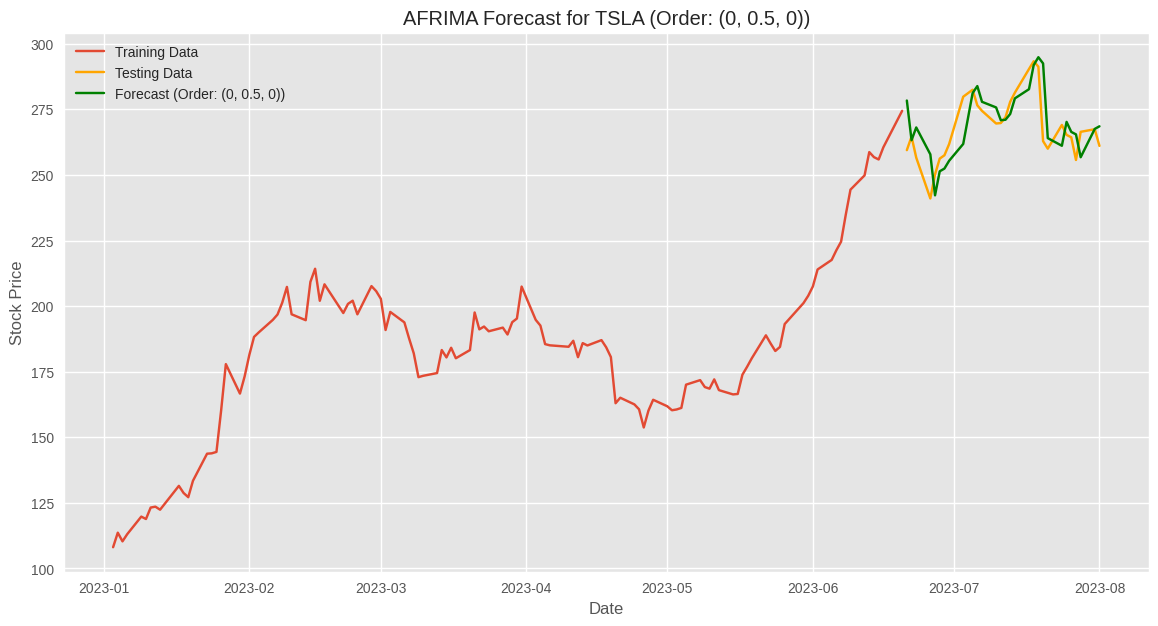

In [141]:
afrima_model.download_data()
best_orders_df = afrima_model.grid_search_afrima_order()  # Grid search for the best order
afrima_model.walk_forward_validation()

## 4.4 AutoRegressive Integrated Moving Average - Generalized Autoregressive Conditional Heteroskedasticity(ARIMA-GARCH)

Combining ARIMA and GARCH: To use ARIMA and GARCH together, you typically need to first fit an ARIMA model and then model the residuals of the ARIMA model with a GARCH model. Here’s a rough outline of the steps:

Fit an ARIMA model to your time series data.
Extract the residuals from the ARIMA model.
Fit a GARCH model to these residuals to model the volatility.

In [142]:
class ARIMAGARCHModel:
    def __init__(self, ticker, start_date, end_date, exog_vars):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.exog_vars = exog_vars
        self.model_order = (0, 1, 0)
        self.garch_order = (1, 1)
        self.train = None
        self.test = None
        self.train_exog = None
        self.test_exog = None
        self.dataset_ex_df = None
        self.history = None
        self.history_exog = None
        self.predictions = []
        self.best_orders = []

    def download_data(self):
        ticker = yf.Ticker(self.ticker)
        self.dataset_ex_df = ticker.history(start=self.start_date, end=self.end_date)
        self.dataset_ex_df.reset_index(inplace=True)
        self.dataset_ex_df['Date'] = pd.to_datetime(self.dataset_ex_df['Date'])
        self.dataset_ex_df.set_index('Date', inplace=True)

        # Drop any rows with missing values
        self.dataset_ex_df.dropna(inplace=True)

        print("Data downloaded and processed. Shape of the dataset:")
        print(self.dataset_ex_df.shape)
        print("\nFirst few rows of the dataset:")
        print(self.dataset_ex_df.head())

    def split_data(self, test_size=0.2):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_vars]

        split_index = int(len(endog) * (1 - test_size))
        self.train, self.test = endog[:split_index], endog[split_index:]
        self.train_exog, self.test_exog = exog[:split_index], exog[split_index:]

    def grid_search_arima_order(self):
        p_values = range(0, 6)
        d_values = range(0, 6)
        q_values = range(0, 6)
        results = []

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = ARIMA(self.train, exog=self.train_exog, order=(p, d, q))
                        model_fit = model.fit()
                        mse = mean_squared_error(self.train, model_fit.fittedvalues)
                        results.append(((p, d, q), mse, model_fit))
                        print(f'ARIMA order {(p, d, q)} MSE={mse}')
                    except Exception as e:
                        continue

        results.sort(key=lambda x: x[1])
        self.best_orders = results[:5]
        self.model_order = self.best_orders[0][0]

        metrics = ['Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC']
        metrics_data = []

        for order, mse, model_fit in self.best_orders:
            y_true = self.train
            y_pred = model_fit.fittedvalues
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
            mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))
            r_squared = r2_score(y_true, y_pred)
            adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(model_fit.params) - 1)
            aic = model_fit.aic
            bic = model_fit.bic

            metrics_data.append([order, mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic])

        best_orders_df = pd.DataFrame(metrics_data, columns=metrics)
        print("Top 5 ARIMA model orders with evaluation metrics:")
        print(best_orders_df)

        return best_orders_df

    def fit_arima_garch(self):
        arima_model = ARIMA(self.train, exog=self.train_exog, order=self.model_order)
        arima_fit = arima_model.fit()
        resid = arima_fit.resid

        garch_model = arch_model(resid, vol='Garch', p=self.garch_order[0], q=self.garch_order[1])
        garch_fit = garch_model.fit(disp="off")

        return arima_fit, garch_fit

    def evaluate_model(self, arima_fit, garch_fit):
        self.history = [x for x in self.train]
        self.history_exog = self.train_exog.values.tolist()
        self.predictions = []

        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1]
            arima_forecast = arima_fit.get_forecast(steps=1, exog=exog).predicted_mean.iloc[0]
            resid = arima_fit.resid.iloc[-1]  # Use the last residual for GARCH forecasting
            garch_forecast = garch_fit.forecast(horizon=1).mean.iloc[-1, 0]

            yhat = arima_forecast + garch_forecast
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog.values[0])

        y_true = self.test
        y_pred = self.predictions

        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
        mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))
        r_squared = r2_score(y_true, y_pred)
        adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(arima_fit.params) - 1)
        aic = arima_fit.aic
        bic = arima_fit.bic

        metrics = {
            'Model': 'ARIMA-GARCH',
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'SMAPE': smape,
            'MASE': mase,
            'R_Squared': r_squared,
            'Adj_R_Squared': adj_r_squared,
            'AIC': aic,
            'BIC': bic
        }

        return metrics

    def plot_results(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label='Forecast (ARIMA-GARCH)', color='green')
        plt.title(f'ARIMA-GARCH Forecast for {self.ticker}')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


In [143]:
# Example usage
arima_garch_model = ARIMAGARCHModel(ticker='TSLA', start_date='2023-01-01', end_date='2023-08-02', exog_vars=['Open', 'High', 'Low', 'Volume'])

arima_garch_model.download_data()
arima_garch_model.split_data()

Data downloaded and processed. Shape of the dataset:
(145, 7)

First few rows of the dataset:
                                 Open        High         Low       Close  \
Date                                                                        
2023-01-03 00:00:00-05:00  118.470001  118.800003  104.639999  108.099998   
2023-01-04 00:00:00-05:00  109.110001  114.589996  107.519997  113.639999   
2023-01-05 00:00:00-05:00  110.510002  111.750000  107.160004  110.339996   
2023-01-06 00:00:00-05:00  103.000000  114.389999  101.809998  113.059998   
2023-01-09 00:00:00-05:00  118.959999  123.519997  117.110001  119.769997   

                              Volume  Dividends  Stock Splits  
Date                                                           
2023-01-03 00:00:00-05:00  231402800        0.0           0.0  
2023-01-04 00:00:00-05:00  180389000        0.0           0.0  
2023-01-05 00:00:00-05:00  157986300        0.0           0.0  
2023-01-06 00:00:00-05:00  220911100        0.

In [144]:

best_orders_df = arima_garch_model.grid_search_arima_order()  # Grid search for the best ARIMA order
arima_fit, garch_fit = arima_garch_model.fit_arima_garch()

# Print custom model summary
print("ARIMA-GARCH Results")
print(arima_fit.summary())

metrics = arima_garch_model.evaluate_model(arima_fit, garch_fit)
print("ARIMA-GARCH Evaluation Metrics:")
print(pd.DataFrame([metrics]))

ARIMA order (0, 0, 0) MSE=5.207543058399863
ARIMA order (0, 0, 1) MSE=5.145649798809953
ARIMA order (0, 0, 2) MSE=4.932638228195288
ARIMA order (0, 0, 3) MSE=4.876200162454222
ARIMA order (0, 0, 4) MSE=4.750896297032147
ARIMA order (0, 0, 5) MSE=4.709900119772228
ARIMA order (0, 1, 0) MSE=15.055395330657078
ARIMA order (0, 1, 1) MSE=12.71090917411598
ARIMA order (0, 1, 2) MSE=12.67474074010445
ARIMA order (0, 1, 3) MSE=12.635232729119606
ARIMA order (0, 1, 4) MSE=12.187275444993045
ARIMA order (0, 1, 5) MSE=12.158327114901152
ARIMA order (0, 2, 0) MSE=41.807120774803195
ARIMA order (0, 2, 1) MSE=41.79738329242242
ARIMA order (0, 2, 2) MSE=41.79737937333623
ARIMA order (0, 2, 3) MSE=41.797378156106625
ARIMA order (0, 2, 4) MSE=24.093292560100167
ARIMA order (0, 2, 5) MSE=23.22897979078774
ARIMA order (0, 3, 0) MSE=116.93409269975508
ARIMA order (0, 3, 1) MSE=116.81444092747039
ARIMA order (0, 3, 2) MSE=116.81437177589457
ARIMA order (0, 3, 3) MSE=116.81430940718155
ARIMA order (0, 3, 4)

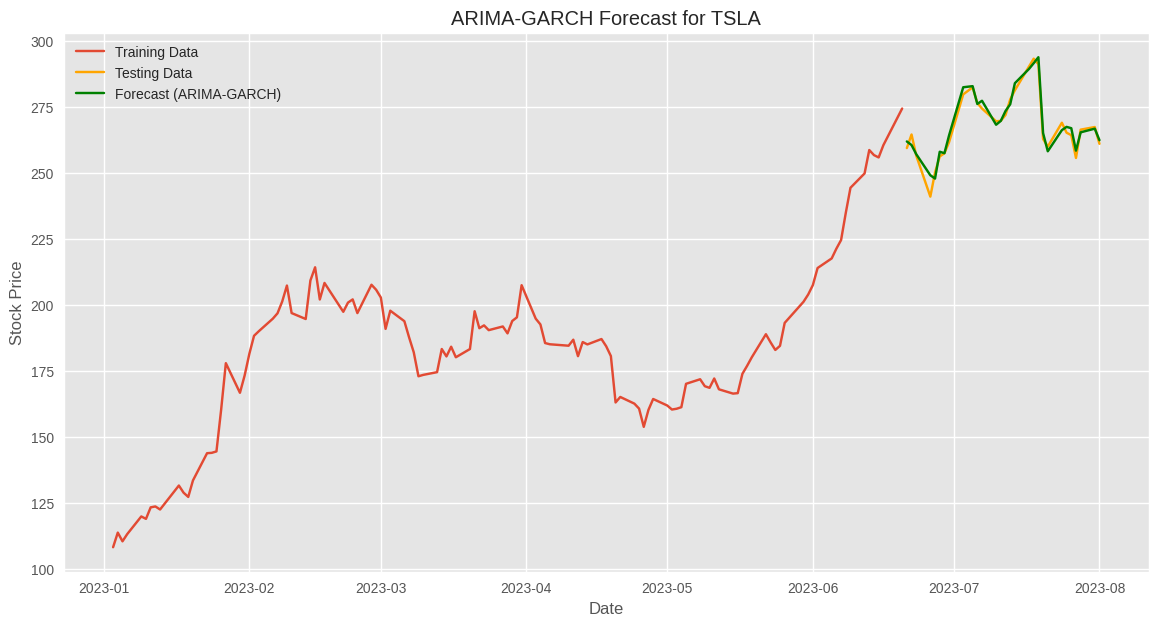

In [145]:
# Plot results
arima_garch_model.plot_results()

In [146]:
# Display the top 5 best orders with evaluation metrics
print("Top 5 ARIMA model orders with their evaluation metrics:")
best_orders_df

Top 5 ARIMA model orders with their evaluation metrics:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
0,"(5, 0, 0)",4.657240,1.713936,2.158064,0.945413,0.944606,inf,0.995539,0.995067,529.963927,560.253419
1,"(5, 0, 1)",4.664099,1.717521,2.159653,0.946718,0.945918,inf,0.995532,0.995012,532.154169,565.197252
2,"(3, 0, 2)",4.672004,1.710713,2.161482,0.944148,0.943350,inf,0.995525,0.995051,530.373845,560.663337
3,"(3, 0, 3)",4.679900,1.709817,2.163308,0.944282,0.943462,inf,0.995517,0.994995,532.658720,565.701802
4,"(4, 0, 5)",4.680224,1.711521,2.163383,0.944596,0.943763,inf,0.995517,0.994844,538.816321,580.120174


#5. Exponential Smoothing Model (ETS)

## 5.1 Simple Exponential Smoothing Model

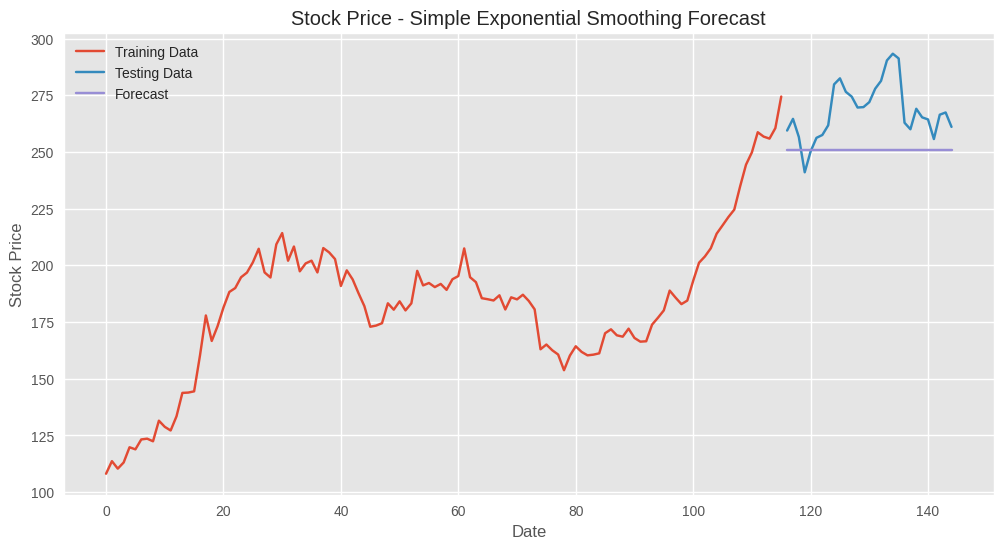

In [169]:
class SimpleExponentialSmoothingModel:
    def __init__(self, data, train_size_ratio=0.8, smoothing_level=0.2):
        self.data = data
        self.train_size_ratio = train_size_ratio
        self.smoothing_level = smoothing_level
        self.split_data()
        self.model = None
        self.fit = None
        self.forecast = None

    def split_data(self):
        train_size = int(len(self.data) * self.train_size_ratio)
        self.train = self.data[:train_size]
        self.test = self.data[train_size:]

    def fit_model(self):
        self.model = SimpleExpSmoothing(self.train)
        self.fit = self.model.fit(smoothing_level=self.smoothing_level, optimized=True)

    def make_forecast(self):
        self.forecast = self.fit.forecast(len(self.test))

    def plot_forecast(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Testing Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.title('Stock Price - Simple Exponential Smoothing Forecast')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def calculate_metrics(self):
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = sqrt(mse)
        mape = np.mean(np.abs((self.test - self.forecast) / self.test)) * 100
        smape = 100/len(self.test) * np.sum(2 * np.abs(self.forecast - self.test) / (np.abs(self.test) + np.abs(self.forecast)))
        mase = mae / np.mean(np.abs(np.diff(self.train)))

        # R-squared
        r_squared = r2_score(self.test, self.forecast)
        n = len(self.test)
        p = 1 # number of predictors
        adj_r_squared = 1 - (1-r_squared)*(n-1)/(n-p-1)

        # AIC and BIC
        aic = n * np.log(mse) + 2 * p
        bic = n * np.log(mse) + np.log(n) * p

        metrics = {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'SMAPE': smape,
            'MASE': mase,
            'R_Squared': r_squared,
            'Adj_R_Squared': adj_r_squared,
            'AIC': aic,
            'BIC': bic
        }

        return metrics

# Use the class
close_prices = df['Close']

ses_model = SimpleExponentialSmoothingModel(close_prices)
ses_model.fit_model()
ses_model.make_forecast()
ses_model.plot_forecast()
metrics = ses_model.calculate_metrics()

# Convert metrics to DataFrame and display
metrics_df = pd.DataFrame(metrics, index=[0])


In [170]:
metrics_df.head()

,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
0,446.276475,17.996224,21.125257,6.547547,6.841641,3.548212,-2.007813,-2.119213,178.927221,180.294517


## 5.2 Holt’s Linear Trend Model

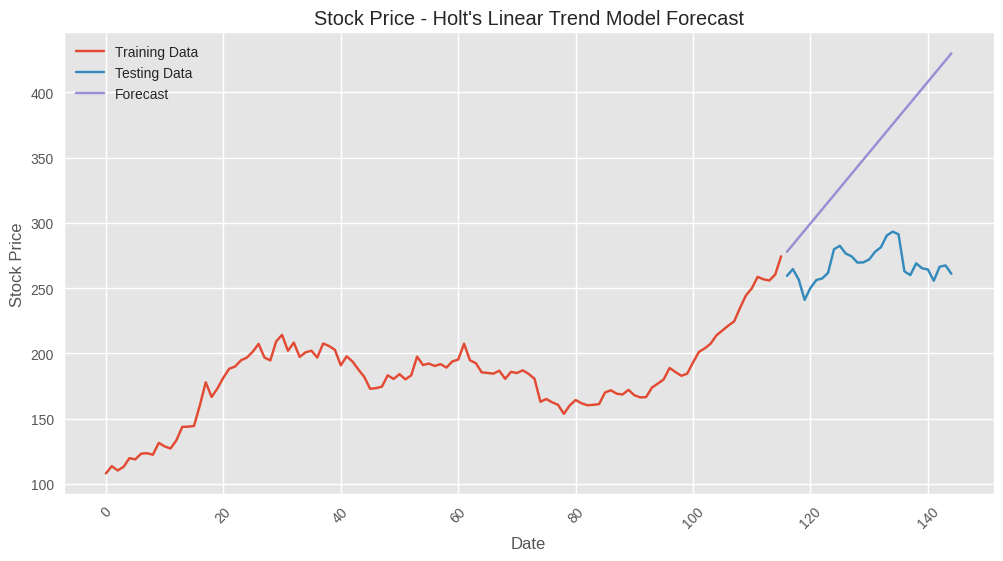

In [173]:
class HoltsLinearTrendModel:
    def __init__(self, data, train_size_ratio=0.8, smoothing_level=0.8, smoothing_trend=0.2):
        self.data = data
        self.train_size_ratio = train_size_ratio
        self.smoothing_level = smoothing_level
        self.smoothing_trend = smoothing_trend
        self.split_data()
        self.model = None
        self.fit = None
        self.forecast = None

    def split_data(self):
        train_size = int(len(self.data) * self.train_size_ratio)
        self.train = self.data[:train_size]
        self.test = self.data[train_size:]

    def fit_model(self):
        self.model = Holt(self.train)
        self.fit = self.model.fit(smoothing_level=self.smoothing_level, smoothing_trend=self.smoothing_trend, optimized=False)

    def make_forecast(self):
        self.forecast = self.fit.forecast(len(self.test))

    def plot_forecast(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Testing Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.title("Stock Price - Holt's Linear Trend Model Forecast")
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

    def calculate_metrics(self):
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = sqrt(mse)
        mape = np.mean(np.abs((self.test - self.forecast) / self.test)) * 100
        smape = 100/len(self.test) * np.sum(2 * np.abs(self.forecast - self.test) / (np.abs(self.test) + np.abs(self.forecast)))
        mase = mae / np.mean(np.abs(np.diff(self.train)))

        # R-squared
        r_squared = r2_score(self.test, self.forecast)
        n = len(self.test)
        p = 1 # number of predictors
        adj_r_squared = 1 - (1-r_squared)*(n-1)/(n-p-1)

        # AIC and BIC
        aic = n * np.log(mse) + 2 * p
        bic = n * np.log(mse) + np.log(n) * p

        metrics = {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'SMAPE': smape,
            'MASE': mase,
            'R_Squared': r_squared,
            'Adj_R_Squared': adj_r_squared,
            'AIC': aic,
            'BIC': bic
        }

        return metrics

# Use the class
# Assuming df is the DataFrame containing your stock price data
close_prices = df['Close']

holt_model = HoltsLinearTrendModel(close_prices)
holt_model.fit_model()
holt_model.make_forecast()
holt_model.plot_forecast()
metrics = holt_model.calculate_metrics()

In [165]:
# Convert metrics to DataFrame and display
metrics_df = pd.DataFrame(metrics, index=[0])
metrics_df

,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
0,9279.238282,85.680633,96.328803,32.01377,26.716887,16.893158,-61.540177,-63.85648,266.930507,268.297803


## 5.3 Holt-Winters Seasonal Model

In [153]:
class HoltWintersModel:
    def __init__(self, data, train_size, seasonal_periods, trend, seasonal):
        self.data = data
        self.train_size = train_size
        self.train = data[:train_size]
        self.test = data[train_size:]
        self.seasonal_periods = seasonal_periods
        self.trend = trend
        self.seasonal = seasonal
        self.model = None
        self.forecast_values = None

    def fit_model(self):
        self.model = ExponentialSmoothing(self.train['Close'],
                                          seasonal_periods=self.seasonal_periods,
                                          trend=self.trend,
                                          seasonal=self.seasonal).fit(optimized=True)

    def forecast(self):
        self.forecast_values = self.model.forecast(len(self.test))
        return self.forecast_values

    def calculate_metrics(self, predictions):
        mse = mean_squared_error(self.test['Close'], predictions)
        mae = mean_absolute_error(self.test['Close'], predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((self.test['Close'] - predictions) / self.test['Close'])) * 100
        smape = np.mean(200 * np.abs(predictions - self.test['Close']) / (np.abs(predictions) + np.abs(self.test['Close'])))
        mae_in_sample = np.mean(np.abs(self.train['Close'].diff().dropna()))
        mase = mae / mae_in_sample
        r_squared = r2_score(self.test['Close'], predictions)
        n = len(self.test)
        p = 1  # number of predictors
        adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
        aic = self.model.aic
        bic = self.model.bic

        metrics_summary = pd.DataFrame({
            'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'],
            'Value': [mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic]
        })

        return metrics_summary

    def plot_results(self, predictions):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train['Close'], color='red', label='Training')
        plt.plot(self.test.index, self.test['Close'], color='blue', label='Testing')
        plt.plot(self.test.index, predictions, color='green', linestyle='dashed', label='Forecast')
        plt.title('Tesla Stock Price - Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

Fitting Holt-Winters Seasonal Model (Additive trend, Additive seasonality):
Model Performance Metrics (Additive seasonality):
          Metric        Value
0            MSE  8836.551395
1            MAE    83.867432
2           RMSE    94.002933
3           MAPE    31.339006
4          SMAPE    26.266615
5           MASE    16.535659
6      R_Squared   -58.556558
7  Adj_R_Squared   -60.762356
8            AIC   433.612883
9            BIC   477.670326


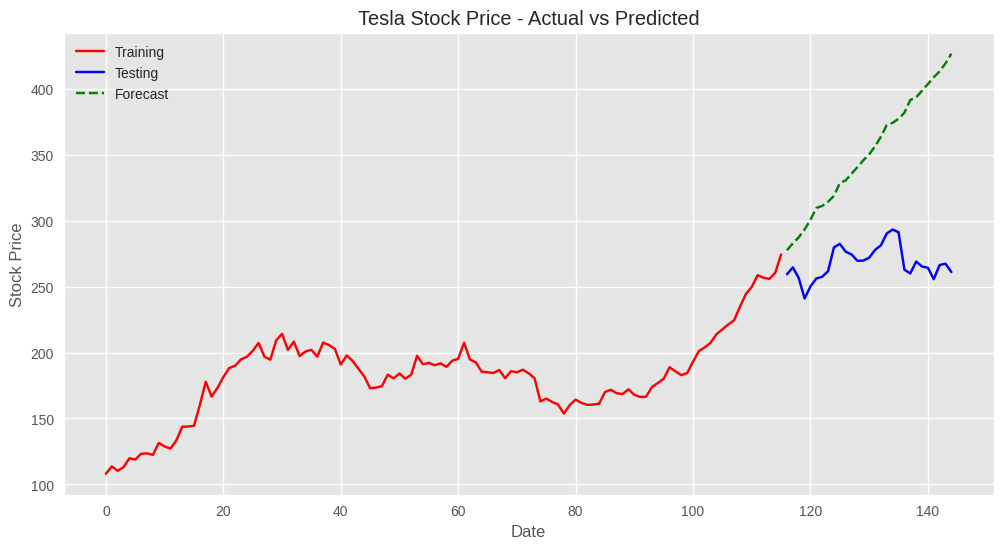

Fitting Holt-Winters Seasonal Model (Additive trend, Multiplicative seasonality):
Model Performance Metrics (Multiplicative seasonality):
          Metric        Value
0            MSE  9039.541634
1            MAE    84.952927
2           RMSE    95.076504
3           MAPE    31.737438
4          SMAPE    26.559162
5           MASE    16.749680
6      R_Squared   -59.924671
7  Adj_R_Squared   -62.181140
8            AIC   434.676664
9            BIC   478.734107


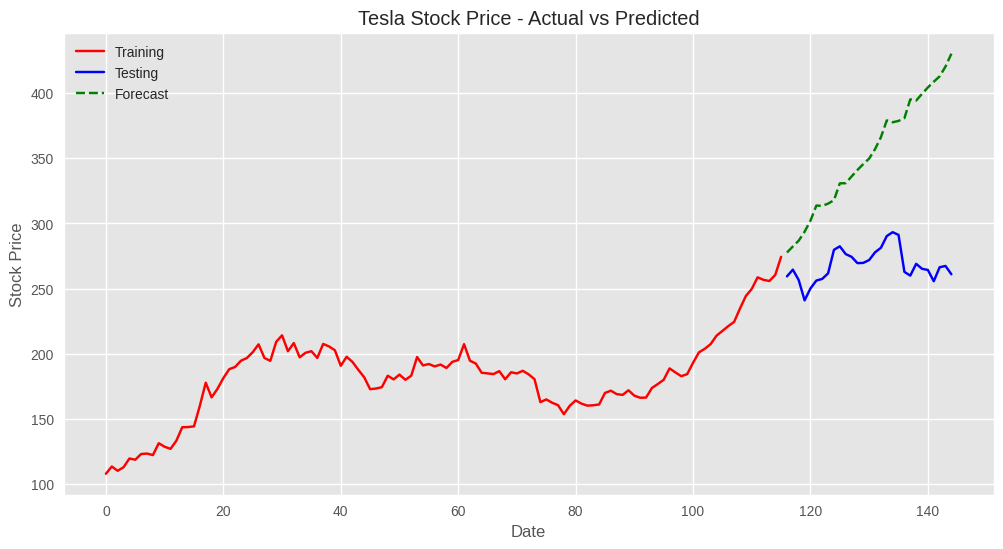

In [154]:
# Initialize and run the model with additive seasonality
model_add = HoltWintersModel(df, train_size, seasonal_periods=12, trend='add', seasonal='add')
print("Fitting Holt-Winters Seasonal Model (Additive trend, Additive seasonality):")
model_add.fit_model()
predictions_add = model_add.forecast()
metrics_add = model_add.calculate_metrics(predictions_add)
print("Model Performance Metrics (Additive seasonality):")
print(metrics_add)
model_add.plot_results(predictions_add)

# Initialize and run the model with multiplicative seasonality
model_mul = HoltWintersModel(df, train_size, seasonal_periods=12, trend='add', seasonal='mul')
print("Fitting Holt-Winters Seasonal Model (Additive trend, Multiplicative seasonality):")
model_mul.fit_model()
predictions_mul = model_mul.forecast()
metrics_mul = model_mul.calculate_metrics(predictions_mul)
print("Model Performance Metrics (Multiplicative seasonality):")
print(metrics_mul)
model_mul.plot_results(predictions_mul)

# 6. Long Short-Term Memory (LSTM)

## 6.1 Simple -LSTM

In [155]:
def lstm(stock_name, data):
    # Choose only Close price of stock
    data = data.filter(['Close'])
    dataset = data.values
    # Train data - 80%, test - 20%
    training_data_len = int(np.ceil( len(dataset) * .80 ))

    # Scale our data from 0 to 1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    # Use our scaled data for training
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print(x_train)
            print(y_train)
            print()

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.35))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Тrain the model
    model.fit(x_train, y_train, batch_size=1, epochs=2)

    # Structure of the model
    keras.utils.plot_model(model, 'simple_lstm.png', show_shapes=True)
    keras.utils.plot_model(model, show_shapes=True)

    # Create test dataset
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Predict on test data
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # For finding error we use RMSE formula, but MSE can be used too
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f'RMSE LSTM: {rmse}')

    # Graphs
    train = data[:training_data_len]
    valid = data[training_data_len:]
    train_gr = train['Close'].values
    valid_gr = valid['Close'].values

    preds_gr = np.reshape(predictions, (50,))

    x_train = list(range(0, len(train_data)))
    x_valid = list(range(len(train_data)-1, len(dataset)))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_train, y=train_gr, mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=x_valid, y=valid_gr, mode='lines+markers', marker=dict(size=4), name='valid', marker_color='#A98D75'))
    fig.add_trace(go.Scatter(x=x_valid, y=preds_gr, mode='lines+markers', marker=dict(size=4), name='predictions', marker_color='#FFAA00'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} LSTM data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

    # Predict stock prices for next moth
    data_new = yf.download(stock_name, start="2021-03-01", end="2021-04-30")

    data_new = data_new.filter(['Close'])
    dataset = data_new.values
    training_data_len = len(dataset)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    test_data = scaled_data[training_data_len - len(data_new): , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(20, len(test_data)):
        x_test.append(test_data[i-20:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    hist_data_new = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data_new = hist_data_new.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data_new = hist_data_new['Close']
    hist_data_new = np.array(hist_data_new)
    pred_lstm = model.predict(x_test)
    pred_lstm = pred_lstm[:-1]
    pred_lstm = scaler.inverse_transform(pred_lstm)


    # build graphs
    preds_gr = np.reshape(pred_lstm, (22,))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data_new, mode='lines+markers',  name='historical', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} LSTM prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

    return pred_lstm, rmse

In [156]:
# getting data from Yahoo Finance
stock_name = 'TSLA'  # here you can change the name of stock ticker, for example we will take AMD ticker
df_data = yf.download(stock_name, start="2020-03-26", end="2021-03-29")

[*********************100%%**********************]  1 of 1 completed


In [157]:
lstm_pred, lstm_rmse = lstm(stock_name, df_data)

[array([0.01860398, 0.01512   , 0.01203238, 0.01755374, 0.00683922,
       0.        , 0.0064479 , 0.01559463, 0.02296907, 0.02382491,
       0.02992441, 0.04960389, 0.06448404, 0.06951815, 0.07340103,
       0.0755924 , 0.07369135, 0.05863448, 0.07009377, 0.06340855,
       0.06833662, 0.08691788, 0.0794374 , 0.08736221, 0.08265883,
       0.06232043, 0.07743537, 0.07920767, 0.08283556, 0.0821943 ,
       0.09213628, 0.09008376, 0.08960913, 0.0849512 , 0.08807415,
       0.08702391, 0.09067453, 0.08925568, 0.09116178, 0.09420143,
       0.09149503, 0.09199742, 0.09234078, 0.08870028, 0.09606966,
       0.11200005, 0.10782433, 0.10817776, 0.10348701, 0.10885941,
       0.12508267, 0.1227474 , 0.14405022, 0.13086913, 0.12138663,
       0.13542859, 0.13321451, 0.13565328, 0.13872575, 0.13795324])]
[0.1362920306495754]

[array([0.01860398, 0.01512   , 0.01203238, 0.01755374, 0.00683922,
       0.        , 0.0064479 , 0.01559463, 0.02296907, 0.02382491,
       0.02992441, 0.04960389, 0.064

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


## 6.2 ARIMA-LSTM Hybrid Model

In [175]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

class HybridARIMALSTM:
    def __init__(self, stock_name, start_date, end_date, window_size=20, epochs=2, learning_rate=0.01, arima_order=(1, 1, 1)):
        self.stock_name = stock_name
        self.start_date = start_date
        self.end_date = end_date
        self.window_size = window_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.arima_order = arima_order
        self.data = None
        self.scaled_data = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def download_data(self):
        self.data = yf.download(self.stock_name, start=self.start_date, end=self.end_date)
        close_prices = self.data['Close'].values.reshape(-1, 1)
        self.scaled_data = self.scaler.fit_transform(close_prices)

    def arima_component(self):
        model = ARIMA(self.data['Close'], order=self.arima_order)
        results = model.fit()
        return results.forecast(steps=len(self.data))

    def simple_nn_component(self):
        np.random.seed(42)
        weights = np.random.randn(self.window_size, 1)
        bias = np.random.randn(1, 1)

        for epoch in range(self.epochs):
            for i in range(self.window_size, len(self.scaled_data)):
                x = self.scaled_data[i - self.window_size:i]
                y = self.scaled_data[i]
                y_pred = np.dot(x.T, weights) + bias
                error = y - y_pred
                weights += self.learning_rate * error * x
                bias += self.learning_rate * error

        predictions = []
        for i in range(self.window_size, len(self.scaled_data)):
            x = self.scaled_data[i - self.window_size:i]
            y_pred = np.dot(x.T, weights) + bias
            predictions.append(y_pred)

        return np.array(predictions).flatten()

    def create_hybrid_model(self):
        self.download_data()

        arima_predictions = self.arima_component()
        nn_predictions = self.simple_nn_component()
        nn_predictions = self.scaler.inverse_transform(nn_predictions.reshape(-1, 1)).flatten()

        hybrid_predictions = 0.5 * arima_predictions[self.window_size:] + 0.5 * nn_predictions

        return self.data.index, self.data['Close'].values, hybrid_predictions

    def evaluate_model(self, actual_prices, predictions):
        mse = mean_squared_error(actual_prices, predictions)
        mae = mean_absolute_error(actual_prices, predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100
        smape = 100/len(actual_prices) * np.sum(2 * np.abs(predictions - actual_prices) / (np.abs(actual_prices) + np.abs(predictions)))
        mase = mae / np.mean(np.abs(actual_prices[:-1] - actual_prices[1:]))
        r_squared = r2_score(actual_prices, predictions)
        adj_r_squared = 1 - (1 - r_squared) * (len(actual_prices) - 1) / (len(actual_prices) - self.window_size - 1)

        n = len(actual_prices)
        k = self.window_size
        aic = n * np.log(mse) + 2 * k
        bic = n * np.log(mse) + np.log(n) * k

        results = {
            "Metric": ["MSE", "MAE", "RMSE", "MAPE", "SMAPE", "MASE", "R_Squared", "Adj_R_Squared", "AIC", "BIC"],
            "Value": [mse, mae, rmse, mape, smape, mase, r_squared, adj_r_squared, aic, bic]
        }
        return pd.DataFrame(results)

    def plot_results(self, dates, actual_prices, hybrid_predictions):
        plt.figure(figsize=(12, 6))
        plt.plot(dates[self.window_size:], actual_prices[self.window_size:], label='Actual Prices')
        plt.plot(dates[self.window_size:], hybrid_predictions, label='Hybrid ARIMA-LSTM Predictions')
        plt.title(f'{self.stock_name} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.gcf().autofmt_xdate()

        plt.tight_layout()
        plt.show()
        print("Chart generated successfully.")


In [176]:
# Usage
TICKER = "TSLA"
start_date = '2020-01-01'
end_date = '2023-01-01'

predictor = HybridARIMALSTM(TICKER, start_date, end_date, window_size=20, epochs=2, learning_rate=0.01)
dates, actual_prices, hybrid_predictions = predictor.create_hybrid_model()

[*********************100%%**********************]  1 of 1 completed


          Metric         Value
0            MSE  57328.658166
1            MAE    200.417854
2           RMSE    239.434037
3           MAPE    122.402588
4          SMAPE    123.657725
5           MASE     31.820460
6      R_Squared     -5.662871
7  Adj_R_Squared     -5.849245
8            AIC   8104.025157
9            BIC   8196.049760


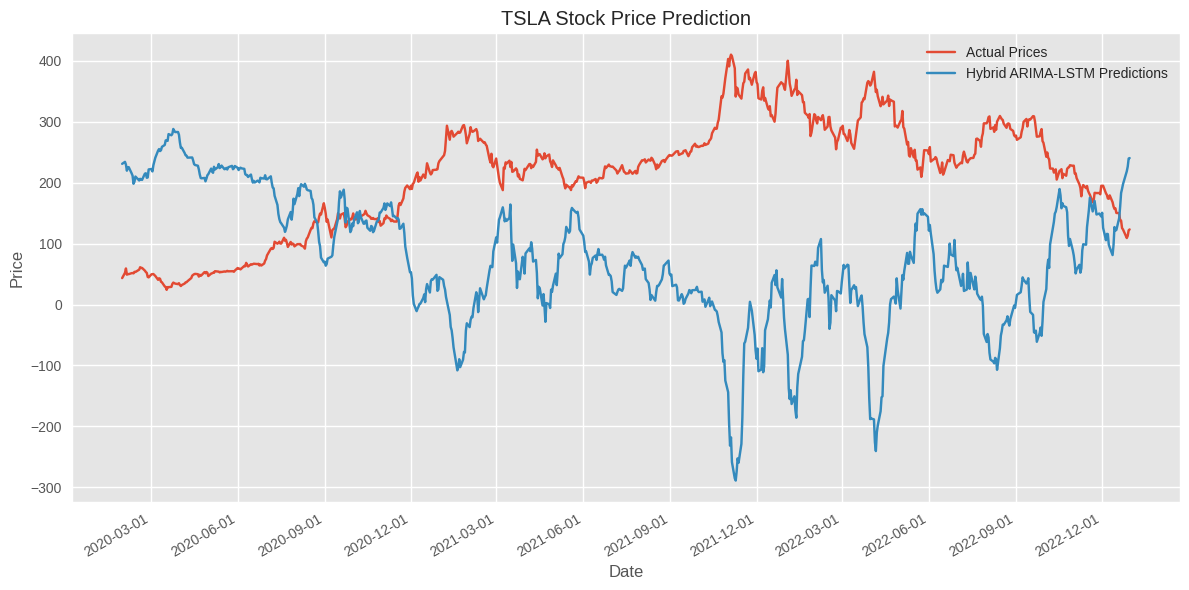

Chart generated successfully.


In [177]:
evaluation_results_df = predictor.evaluate_model(actual_prices[predictor.window_size:], hybrid_predictions)
print(evaluation_results_df)
predictor.plot_results(dates, actual_prices, hybrid_predictions)